### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

from textwrap import wrap

import seaborn as sns

### Loading the data

In [4]:
official_names = ['Benzyl_benzoate', 'm Anisaldehyde']

In [5]:
os.getcwd()

'/home/basia/Documents/spectroscopy/magnetstein_data/experiment_3_overlapping_and_intensity_difference'

In [6]:
mix = np.loadtxt(os.getcwd()+'/m_anisaldehyde_benzylbenzoate_nakrywajace_sie_I_dyzy_zakres+intensywnosci_pikow.csv', skiprows=0, usecols=range(2), 
                      delimiter='\t',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library.csv', skiprows=1, usecols=[0, 2, 4],
                      delimiter='\t',dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [7]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [8]:
spectra = []
for comp_ints in components_ints:
    spectra.append(Spectrum(confs=list(zip(ppm_components, comp_ints))))

In [9]:
mix = Spectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


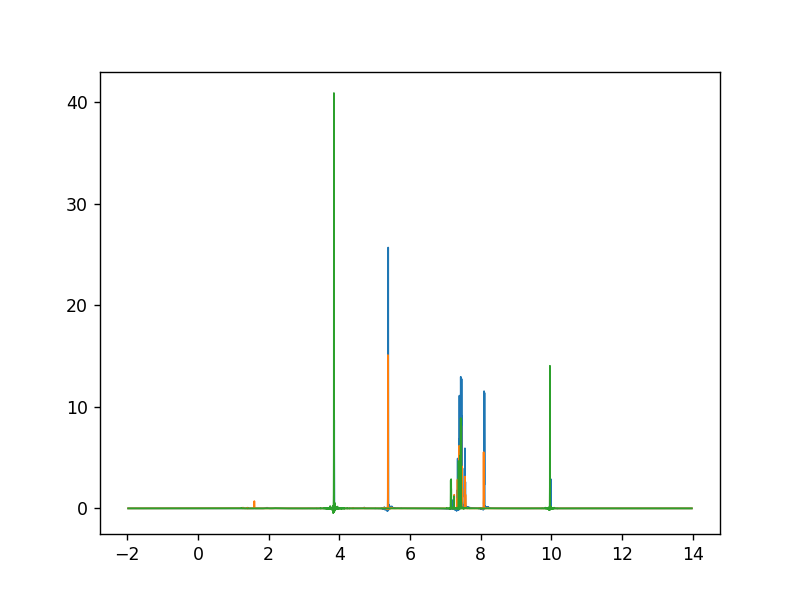

In [10]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)

### Ground truth

In [11]:
protons = [12, 8]
mass_proportions = [0.8914, 0.1086]
molar_masses = [212.25, 136.15]

In [12]:
molar_proportions = [mass_prop/mol_mass for mass_prop, mol_mass in zip(mass_proportions, molar_masses)]
molar_proportions = [mol_prop/sum(molar_proportions) for mol_prop in molar_proportions]
molar_proportions

[0.8403875207510383, 0.1596124792489616]

In [13]:
real_visible_proportions = [prot*prop for prot, prop in zip(protons, molar_proportions)]
real_visible_proportions = [prop/sum(real_visible_proportions) for prop in real_visible_proportions]
real_visible_proportions

[0.8876121810260892, 0.1123878189739109]

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        shift_coef = (min_of_min - epsilon)*(-1)
        for i, arr in enumerate(old_confs):
            new_ppm_non_unique = arr[:,0] + shift_coef
            resampled = res[i].resample(np.unique(new_ppm_non_unique) - shift_coef)
            new_ppm_unique = np.array(resampled.confs)[:,0]
            new_ints = np.array(resampled.confs)[:,1]
            res[i] = Spectrum(confs=list(zip(new_ppm_unique + shift_coef, new_ints)))
        return(res)
    else:
        return(list_of_spectra)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = Spectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
spectra_and_mixture = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [27]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [28]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

<IPython.core.display.Javascript object>


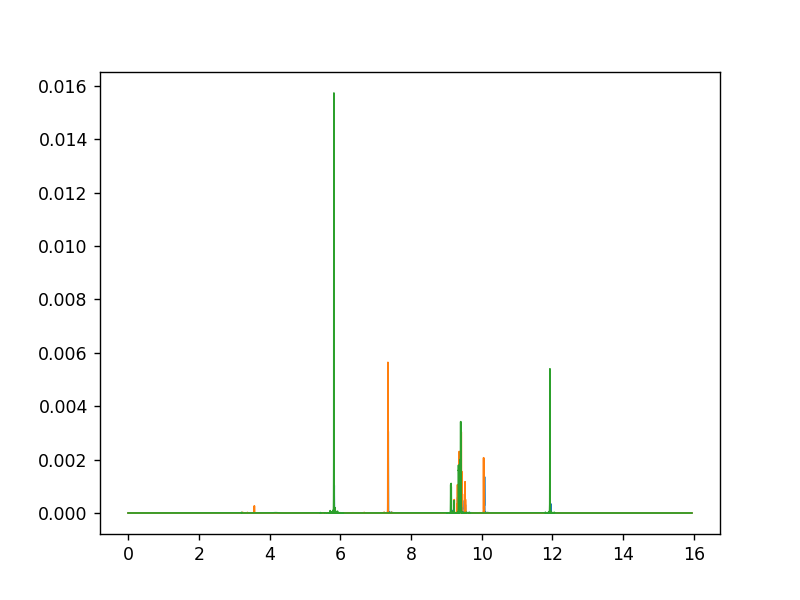

In [29]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 

### Finding best kappa

In [30]:
import time
import pandas as pd
import pulp

In [31]:
# lower_limit = 0.01
# upper_limit = 0.3
# step = 0.01

In [49]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 28149.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3232906.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.29s/it]


Estimation for 0.01 and 0.01 done
It took: 150.44320917129517 seconds.
[0.7131499470590109, 0.061583023606000944]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3159734.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.09s/it]


Estimation for 0.01 and 0.02 done
It took: 158.23815989494324 seconds.
[0.6818430517780104, 0.03988604873600061]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440360.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.74s/it]


Estimation for 0.01 and 0.03 done
It took: 152.88273572921753 seconds.
[0.6756350670660103, 0.03570759514600055]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470395.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.32s/it]


Estimation for 0.01 and 0.04 done
It took: 166.4679479598999 seconds.
[0.6736811395120104, 0.02936411848600045]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534747.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.88s/it]


Estimation for 0.01 and 0.05 done
It took: 169.0271077156067 seconds.
[0.6648899683840103, 0.023161998115000353]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490779.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.85s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 157.00356912612915 seconds.
[0.65299448930501, 0.019674234804000303]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3662841.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.54s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 145.67477202415466 seconds.
[0.6417060171550099, 0.018272143282000282]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3623155.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.09s/it]


Estimation for 0.01 and 0.08 done
It took: 161.2395842075348 seconds.
[0.6308872284800097, 0.01697428194800026]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3590617.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.95s/it]


Estimation for 0.01 and 0.09 done
It took: 155.0872483253479 seconds.
[0.6209603634900095, 0.015835508742000244]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539686.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.95s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 164.09250330924988 seconds.
[0.6125844686020094, 0.014761612802000225]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3519924.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:37<00:00, 877.70s/it]


Estimation for 0.01 and 0.11 done
It took: 877.8355631828308 seconds.
[0.5978096598140091, 0.014075572377000216]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567919.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.89s/it]


Estimation for 0.01 and 0.12 done
It took: 164.0304205417633 seconds.
[0.5828511027170089, 0.013434241440000206]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3046785.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:49<00:00, 229.68s/it]


Estimation for 0.01 and 0.13 done
It took: 229.84480595588684 seconds.
[0.5679465599010086, 0.012898453444000198]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3555896.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:00<00:00, 180.08s/it]


Estimation for 0.01 and 0.14 done
It took: 180.2343249320984 seconds.
[0.5512881064570084, 0.012747086864000196]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466413.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.03s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 171.18220281600952 seconds.
[0.5385447016460082, 0.012553689273000192]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451440.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.02s/it]


Estimation for 0.01 and 0.16 done
It took: 183.186265707016 seconds.
[0.523265957659008, 0.01232645291700019]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3062194.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [05:55<00:00, 355.40s/it]


Estimation for 0.01 and 0.17 done
It took: 355.5725543498993 seconds.
[0.5100928432560078, 0.012221787074000188]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542309.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.82s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 146.97002172470093 seconds.
[0.4972451154460076, 0.012151568081000185]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3589304.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:08<00:00, 188.06s/it]


Estimation for 0.01 and 0.19 done
It took: 188.2014889717102 seconds.
[0.4855522652710074, 0.012099935111000186]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3609784.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.54s/it]


Estimation for 0.01 and 0.2 done
It took: 157.67475485801697 seconds.
[0.47445915651200726, 0.012103289277000186]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467550.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.33s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 151.47101068496704 seconds.
[0.4627170656820071, 0.012023066569000184]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3524979.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [08:25<00:00, 505.17s/it]


Estimation for 0.01 and 0.22 done
It took: 505.32753252983093 seconds.
[0.45316855359100694, 0.011864558277000182]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3484694.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.57s/it]


Estimation for 0.01 and 0.23 done
It took: 149.7307424545288 seconds.
[0.4434791001010068, 0.011694561967000179]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3558566.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:23<00:00, 203.34s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 203.49013090133667 seconds.
[0.4351442175810067, 0.011511562955000177]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3555436.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 144.00s/it]


Estimation for 0.01 and 0.25 done
It took: 144.15374445915222 seconds.
[0.4248763530830065, 0.011465447604000175]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528124.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:36<00:00, 216.04s/it]


Estimation for 0.01 and 0.26 done
It took: 216.17141604423523 seconds.
[0.4149007870640064, 0.011386200036000176]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494129.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.35s/it]


Estimation for 0.01 and 0.27 done
It took: 147.49711275100708 seconds.
[0.40095033422200616, 0.011390883275000175]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3527376.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:45<00:00, 165.85s/it]


Estimation for 0.01 and 0.28 done
It took: 165.99196815490723 seconds.
[0.38934516868500596, 0.011279017755000174]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3459999.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:20<00:00, 200.18s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 200.33386874198914 seconds.
[0.37540776547000576, 0.011265708087000172]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3459454.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.80s/it]


Estimation for 0.02 and 0.01 done
It took: 172.95387053489685 seconds.
[0.8330947636540128, 0.08622385066500132]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542218.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.92s/it]


Estimation for 0.02 and 0.02 done
It took: 170.05296349525452 seconds.
[0.8012450679570123, 0.1038553529450016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453044.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.28s/it]


Estimation for 0.02 and 0.03 done
It took: 150.41986298561096 seconds.
[0.8033614037500123, 0.08652909667200133]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411708.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.66s/it]


Estimation for 0.02 and 0.04 done
It took: 131.802250623703 seconds.
[0.7911702775760121, 0.08773534883500135]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476408.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.35s/it]


Estimation for 0.02 and 0.05 done
It took: 130.50220727920532 seconds.
[0.779410600867012, 0.08913104749400136]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3538980.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.45s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 146.59207963943481 seconds.
[0.7723476834290118, 0.08483715804800131]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3555965.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.01s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 136.16602540016174 seconds.
[0.7633261803940117, 0.07989706347900122]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3543314.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.12s/it]


Estimation for 0.02 and 0.08 done
It took: 140.2610056400299 seconds.
[0.7656791783750118, 0.06092856438100094]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3563040.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.68s/it]


Estimation for 0.02 and 0.09 done
It took: 119.82034754753113 seconds.
[0.7640566816430117, 0.04783384278600074]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487789.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.43s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 137.5703775882721 seconds.
[0.7581271428480116, 0.0457384519040007]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471666.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.79s/it]


Estimation for 0.02 and 0.11 done
It took: 137.92844223976135 seconds.
[0.7530917665090116, 0.04417324491000068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453587.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.76s/it]


Estimation for 0.02 and 0.12 done
It took: 149.90339064598083 seconds.
[0.7468148521950114, 0.04182580208200064]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3580561.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.70s/it]


Estimation for 0.02 and 0.13 done
It took: 160.83879375457764 seconds.
[0.7418276356060113, 0.04208560320000065]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409042.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.81s/it]


Estimation for 0.02 and 0.14 done
It took: 157.96585369110107 seconds.
[0.7411220988280113, 0.042129089325000646]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3489316.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.38s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 145.5158519744873 seconds.
[0.7403087321760113, 0.04212463955600065]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3511448.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.74s/it]


Estimation for 0.02 and 0.16 done
It took: 148.88207745552063 seconds.
[0.7393255022840113, 0.04216294555600065]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485356.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.76s/it]


Estimation for 0.02 and 0.17 done
It took: 153.90389728546143 seconds.
[0.7381390489850114, 0.04241762395300065]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3591297.45it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [21:22<00:00, 1282.15s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 1282.2873787879944 seconds.
[0.7367830951240113, 0.04267027087900065]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 53773.13it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3588999.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.11s/it]


Estimation for 0.02 and 0.19 done
It took: 135.2659251689911 seconds.
[0.7351218801760112, 0.042959332462000656]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3602286.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.21s/it]


Estimation for 0.02 and 0.2 done
It took: 131.34841680526733 seconds.
[0.7332020272840112, 0.04332312296000067]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528848.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.72s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 152.85317492485046 seconds.
[0.7308633221880112, 0.04369127381300067]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485843.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.32s/it]


Estimation for 0.02 and 0.22 done
It took: 136.46437525749207 seconds.
[0.7284001303110113, 0.043994119147000674]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517896.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.87s/it]


Estimation for 0.02 and 0.23 done
It took: 137.01458859443665 seconds.
[0.7264743124700112, 0.04420178877800068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3501941.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.51s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 137.65211963653564 seconds.
[0.7241492581910111, 0.04433051185800068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3544936.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.54s/it]


Estimation for 0.02 and 0.25 done
It took: 134.68055057525635 seconds.
[0.7215114021550111, 0.04445218435000068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521502.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.20s/it]


Estimation for 0.02 and 0.26 done
It took: 131.34950065612793 seconds.
[0.721154628036011, 0.04453932101200068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3520284.65it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [52:40<00:00, 3160.91s/it]


Estimation for 0.02 and 0.27 done
It took: 3161.048358440399 seconds.
[0.720259367987011, 0.04468300964500069]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3180077.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.39s/it]


Estimation for 0.02 and 0.28 done
It took: 153.54299116134644 seconds.
[0.719235941110011, 0.044839823150000686]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29330.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3277271.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.71s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 145.87711429595947 seconds.
[0.718194434068011, 0.044997026169000684]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63072.24it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3387949.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.29s/it]


Estimation for 0.03 and 0.01 done
It took: 128.44106101989746 seconds.
[0.8759602211430134, 0.08335030329500127]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430613.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.11s/it]


Estimation for 0.03 and 0.02 done
It took: 121.28526091575623 seconds.
[0.8252598873750127, 0.10444547782500159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 52103.16it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2930202.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.99s/it]


Estimation for 0.03 and 0.03 done
It took: 128.17963361740112 seconds.
[0.8158312929100126, 0.10562998654400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3418029.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.61s/it]


Estimation for 0.03 and 0.04 done
It took: 168.760657787323 seconds.
[0.8135510316650124, 0.10346676768800159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461742.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [14:14<00:00, 854.90s/it]


Estimation for 0.03 and 0.05 done
It took: 855.0484704971313 seconds.
[0.8127024908050124, 0.09037602226800139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3113581.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.68s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 124.82526087760925 seconds.
[0.8055119117190124, 0.08985278046200137]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3516119.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.08s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 168.23621463775635 seconds.
[0.8018259923220123, 0.08733562091400134]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3558773.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.46s/it]


Estimation for 0.03 and 0.08 done
It took: 130.60433268547058 seconds.
[0.8032565070550123, 0.08248048968900126]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521096.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.98s/it]


Estimation for 0.03 and 0.09 done
It took: 152.1212558746338 seconds.
[0.8028355287380123, 0.0712574895430011]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3463377.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.22s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 130.38698530197144 seconds.
[0.8120113439970125, 0.0589404330270009]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454802.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.62s/it]


Estimation for 0.03 and 0.11 done
It took: 128.7631537914276 seconds.
[0.8196983800060126, 0.04930377144100075]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3596466.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.43s/it]


Estimation for 0.03 and 0.12 done
It took: 158.5686662197113 seconds.
[0.8235856266660126, 0.044017575400000675]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3540074.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.77s/it]


Estimation for 0.03 and 0.13 done
It took: 162.91077494621277 seconds.
[0.8250809935160126, 0.04137055492400063]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541739.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.89s/it]


Estimation for 0.03 and 0.14 done
It took: 137.02500247955322 seconds.
[0.8256686145330127, 0.03982006789400061]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45839.39it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396321.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.18s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 145.31642889976501 seconds.
[0.8259012677680126, 0.0387694158670006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471009.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.82s/it]


Estimation for 0.03 and 0.16 done
It took: 153.98520016670227 seconds.
[0.8258185626000126, 0.03863599324200059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3460042.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.74s/it]


Estimation for 0.03 and 0.17 done
It took: 162.89860033988953 seconds.
[0.8257902347630126, 0.03852104651500059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541305.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.59s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 140.73006939888 seconds.
[0.8257554385620126, 0.03841465131600059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502187.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.78s/it]


Estimation for 0.03 and 0.19 done
It took: 153.91938710212708 seconds.
[0.8254669066350127, 0.03828584683100059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507818.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.80s/it]


Estimation for 0.03 and 0.2 done
It took: 153.94307708740234 seconds.
[0.8251783958970127, 0.038252929789000585]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487258.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.31s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 183.45292568206787 seconds.
[0.8246470540400127, 0.03829693442100059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3463159.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.16s/it]


Estimation for 0.03 and 0.22 done
It took: 183.30384397506714 seconds.
[0.8244342885440127, 0.03834469251400059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476738.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.53s/it]


Estimation for 0.03 and 0.23 done
It took: 142.67201495170593 seconds.
[0.8239705425150127, 0.03839662531600059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3605145.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:53<00:00, 173.40s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 173.53275871276855 seconds.
[0.8236841819770127, 0.03849448551200059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3522901.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.88s/it]


Estimation for 0.03 and 0.25 done
It took: 148.02070593833923 seconds.
[0.8233634069610126, 0.03862495792600059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3481362.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.69s/it]


Estimation for 0.03 and 0.26 done
It took: 146.85208082199097 seconds.
[0.8229997947590126, 0.0387253627150006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3301757.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.96s/it]


Estimation for 0.03 and 0.27 done
It took: 131.10388374328613 seconds.
[0.8228761976490127, 0.0387365124990006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502901.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:09<00:00, 189.16s/it]


Estimation for 0.03 and 0.28 done
It took: 189.30224227905273 seconds.
[0.8225888394390126, 0.038811859787000594]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3499734.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.84s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 123.97361588478088 seconds.
[0.8224651535040126, 0.0387927936680006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485445.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.84s/it]


Estimation for 0.04 and 0.01 done
It took: 149.98548316955566 seconds.
[0.8840633927580136, 0.08433932777700129]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3583315.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.00s/it]


Estimation for 0.04 and 0.02 done
It took: 119.16436314582825 seconds.
[0.8352683577410127, 0.10308576820400159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464250.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.05s/it]


Estimation for 0.04 and 0.03 done
It took: 129.18643450737 seconds.
[0.8268168084620127, 0.10551887140200161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490579.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.31s/it]


Estimation for 0.04 and 0.04 done
It took: 129.46559238433838 seconds.
[0.8235267875210126, 0.10546327646200161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450985.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.76s/it]


Estimation for 0.04 and 0.05 done
It took: 150.90684580802917 seconds.
[0.8184925255990125, 0.10526323392500161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3422412.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.86s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 156.9994785785675 seconds.
[0.8168931059940125, 0.1042092509210016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3489161.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.32s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 142.45582461357117 seconds.
[0.8164427534750125, 0.09970673987800152]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3583946.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.40s/it]


Estimation for 0.04 and 0.08 done
It took: 130.53578519821167 seconds.
[0.8185142057900126, 0.0907990646860014]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531795.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.79s/it]


Estimation for 0.04 and 0.09 done
It took: 155.9469084739685 seconds.
[0.8161321601600126, 0.09002318586100137]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3552357.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.99s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 159.1475067138672 seconds.
[0.8164710025280125, 0.08375849583700128]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528780.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.67s/it]


Estimation for 0.04 and 0.11 done
It took: 131.80969715118408 seconds.
[0.8211696661160125, 0.06600283522700101]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453456.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.26s/it]


Estimation for 0.04 and 0.12 done
It took: 161.40415239334106 seconds.
[0.8248724539140126, 0.056850317476000875]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3444326.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.99s/it]


Estimation for 0.04 and 0.13 done
It took: 129.1359875202179 seconds.
[0.8295085009400126, 0.049777284216000764]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445837.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.66s/it]


Estimation for 0.04 and 0.14 done
It took: 129.80125856399536 seconds.
[0.8313768733720127, 0.04600131484700071]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496729.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.05s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 139.19715356826782 seconds.
[0.8328693216800128, 0.04207081524100065]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3633788.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.72s/it]


Estimation for 0.04 and 0.16 done
It took: 145.88350129127502 seconds.
[0.8333953481420128, 0.040160909551000615]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532930.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.59s/it]


Estimation for 0.04 and 0.17 done
It took: 133.72989320755005 seconds.
[0.8335727048930127, 0.0395652873730006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488586.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.40s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 150.54321670532227 seconds.
[0.8335248301280128, 0.0395283449950006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517851.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.56s/it]


Estimation for 0.04 and 0.19 done
It took: 152.70106482505798 seconds.
[0.8333940486040128, 0.039458324651000604]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451895.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.77s/it]


Estimation for 0.04 and 0.2 done
It took: 154.91058659553528 seconds.
[0.8333392418820128, 0.0394364558750006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468687.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.91s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 153.06788396835327 seconds.
[0.8332130054910127, 0.0393738460320006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3594326.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.64s/it]


Estimation for 0.04 and 0.22 done
It took: 150.78401231765747 seconds.
[0.8332392501960127, 0.03919689392000061]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3524595.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.11s/it]


Estimation for 0.04 and 0.23 done
It took: 147.24443578720093 seconds.
[0.8332814629610128, 0.0391280746360006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3530911.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.96s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 140.1017713546753 seconds.
[0.8332929060480128, 0.03909427691500059]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3537067.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.00s/it]


Estimation for 0.04 and 0.25 done
It took: 132.13895988464355 seconds.
[0.8331159951390128, 0.0391044218390006]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3457931.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.21s/it]


Estimation for 0.04 and 0.26 done
It took: 155.35088562965393 seconds.
[0.8330602380840127, 0.03919090232700061]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487612.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.23s/it]


Estimation for 0.04 and 0.27 done
It took: 150.36871671676636 seconds.
[0.8329547672240127, 0.039283424220000605]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3626788.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.61s/it]


Estimation for 0.04 and 0.28 done
It took: 131.75558304786682 seconds.
[0.8325880957160128, 0.039333144207000605]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3460434.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.09s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 153.23563766479492 seconds.
[0.8325528902660128, 0.039415115877000605]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3512726.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.95s/it]


Estimation for 0.05 and 0.01 done
It took: 115.09057331085205 seconds.
[0.8868643834470136, 0.08782616640400134]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3564010.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.63s/it]


Estimation for 0.05 and 0.02 done
It took: 153.76284289360046 seconds.
[0.845840682730013, 0.10100678777100155]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3457431.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.27s/it]


Estimation for 0.05 and 0.03 done
It took: 131.43451642990112 seconds.
[0.8315562963630128, 0.10554811106100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534543.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.58s/it]


Estimation for 0.05 and 0.04 done
It took: 127.7158715724945 seconds.
[0.8299577606360128, 0.1054417397200016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3289370.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.44s/it]


Estimation for 0.05 and 0.05 done
It took: 162.5848410129547 seconds.
[0.8281424176480127, 0.10546224779500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3690899.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.63s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 153.78102254867554 seconds.
[0.8255835393130126, 0.10526450565100161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567040.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.40s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 126.53530359268188 seconds.
[0.8226620378310127, 0.10481841520000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3592353.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.87s/it]


Estimation for 0.05 and 0.08 done
It took: 148.00912046432495 seconds.
[0.8215801909010125, 0.1045032658670016]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494884.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.71s/it]


Estimation for 0.05 and 0.09 done
It took: 125.86548352241516 seconds.
[0.8217657330480126, 0.10337580587400158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534157.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.53s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 130.69266533851624 seconds.
[0.8214726736540126, 0.10218346632100157]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3486196.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.26s/it]


Estimation for 0.05 and 0.11 done
It took: 150.41265416145325 seconds.
[0.8254505089840126, 0.09202429969400142]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406317.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.12s/it]


Estimation for 0.05 and 0.12 done
It took: 128.2696967124939 seconds.
[0.8258050247140126, 0.09034751517500139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405979.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.48s/it]


Estimation for 0.05 and 0.13 done
It took: 128.62052822113037 seconds.
[0.8275986454260127, 0.08655219381700133]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3501607.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:50<00:00, 170.66s/it]


Estimation for 0.05 and 0.14 done
It took: 170.79822421073914 seconds.
[0.8306565450630128, 0.07997157420600122]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3418751.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.42s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 145.58564710617065 seconds.
[0.8327004504880128, 0.06992856154000107]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3608576.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.15s/it]


Estimation for 0.05 and 0.16 done
It took: 150.29902601242065 seconds.
[0.8353720464570128, 0.06221948571300095]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3576112.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.00s/it]


Estimation for 0.05 and 0.17 done
It took: 131.1493570804596 seconds.
[0.8383305876040129, 0.05379268791100083]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445902.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.83s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 154.9699945449829 seconds.
[0.8408437053230129, 0.046146845214000705]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3503191.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.74s/it]


Estimation for 0.05 and 0.19 done
It took: 149.88065099716187 seconds.
[0.8405561739200129, 0.04616970133500071]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567156.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.39s/it]


Estimation for 0.05 and 0.2 done
It took: 156.52837800979614 seconds.
[0.8402341177280129, 0.0458761268410007]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567248.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.17s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 136.30489993095398 seconds.
[0.8398433259090129, 0.045476837849000695]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3484672.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.86s/it]


Estimation for 0.05 and 0.22 done
It took: 131.99761319160461 seconds.
[0.8395172937550128, 0.0455426765930007]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3506475.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.06s/it]


Estimation for 0.05 and 0.23 done
It took: 150.19960498809814 seconds.
[0.8391477645120129, 0.045231885292000694]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496685.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.29s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 162.43185710906982 seconds.
[0.8388804063610129, 0.04508526816900069]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507594.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.97s/it]


Estimation for 0.05 and 0.25 done
It took: 153.10506200790405 seconds.
[0.8387800644210128, 0.0450766925890007]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3522540.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.33s/it]


Estimation for 0.05 and 0.26 done
It took: 155.47302198410034 seconds.
[0.8384449064260129, 0.04467989195400069]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380491.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.38s/it]


Estimation for 0.05 and 0.27 done
It took: 146.54603338241577 seconds.
[0.8383850247230129, 0.04460010425700068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40721.40it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470855.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.92s/it]


Estimation for 0.05 and 0.28 done
It took: 140.06324434280396 seconds.
[0.8383470834860128, 0.04441987203600068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3305410.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.34s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 152.48978972434998 seconds.
[0.8383242771810129, 0.04453517314100068]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37617.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3413996.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.21s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 118.35563373565674 seconds.
[0.8821369414650135, 0.09553862006000145]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3546468.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.96s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 155.09747219085693 seconds.
[0.851105689042013, 0.10028543259600153]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471316.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.28s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 136.44272828102112 seconds.
[0.8364746785830127, 0.1052505621360016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3358518.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.56s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 133.72630548477173 seconds.
[0.8331138749960127, 0.10573660042600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3257136.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.76s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 128.91355395317078 seconds.
[0.8318188969230128, 0.10561416096500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3459215.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.78s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 125.92452383041382 seconds.
[0.8311104861820128, 0.10518288683700161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3382925.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.91s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 130.07412123680115 seconds.
[0.8292149251850126, 0.1051673633640016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526290.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.90s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 149.03605818748474 seconds.
[0.8269836417790126, 0.10517773257700161]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3462243.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.70s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 122.84326815605164 seconds.
[0.8259129870020127, 0.10506493557900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3540666.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.04s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 161.17750883102417 seconds.
[0.8251881702930126, 0.1044814099730016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496329.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.42s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 130.58115339279175 seconds.
[0.8239662748910127, 0.10427212819500159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502700.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.26s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 125.40313458442688 seconds.
[0.8239384141380126, 0.10183049877000155]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464600.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:54<00:00, 174.83s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 174.96755480766296 seconds.
[0.8276934304680127, 0.09514840191100146]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3383133.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.21s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 127.3589768409729 seconds.
[0.8292385888910127, 0.0913649880800014]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3480061.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.08s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 128.2177128791809 seconds.
[0.8295185256990126, 0.09062776286000139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447436.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.84s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 130.98512434959412 seconds.
[0.8305419698620128, 0.08794646320600134]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3527263.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.47s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 152.61362838745117 seconds.
[0.8337496113320128, 0.08201786044600126]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467528.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.85s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 133.9920952320099 seconds.
[0.8385404322100128, 0.07427497485900114]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451050.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.81s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 171.95191502571106 seconds.
[0.8439224953540129, 0.06283503965800095]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3592611.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.39s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 129.52474999427795 seconds.
[0.8439196228400129, 0.06277560168900095]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3538524.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.98s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 149.11732411384583 seconds.
[0.8438862308050129, 0.06273712160000096]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3545393.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.87s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 149.0377061367035 seconds.
[0.8438971882510129, 0.06259954695300096]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485622.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.87s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 152.0065221786499 seconds.
[0.8438654087410129, 0.06266271470500095]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424160.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.14s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 131.31059670448303 seconds.
[0.8437562112950129, 0.06276477238700096]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3403913.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.50s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 155.66813445091248 seconds.
[0.8437209877960129, 0.06279951950500096]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478102.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.24s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 148.38197946548462 seconds.
[0.8436997897040128, 0.06285383827700096]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69327.34it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409232.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.41s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 128.58134245872498 seconds.
[0.8435928676690129, 0.06303967729000097]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526992.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.06s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 145.19980192184448 seconds.
[0.8436445371390129, 0.06319273791600097]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3333873.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.71s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 138.86769890785217 seconds.
[0.8436589553510129, 0.06342083434100097]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532022.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.99s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 112.1281578540802 seconds.
[0.8697424924890134, 0.10992191965400168]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43690.67it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3382987.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.25s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 160.411283493042 seconds.
[0.8565536822470131, 0.09904562825600151]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3596160.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.90s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 123.0385434627533 seconds.
[0.8408595949640129, 0.10483610308100161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542811.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.37s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 130.50330924987793 seconds.
[0.8369858905750128, 0.10567078741600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470111.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.81s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 124.97308921813965 seconds.
[0.8353531261390128, 0.10577100021400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3583175.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.29s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 128.41923999786377 seconds.
[0.8342564756480128, 0.10541233055900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3559096.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.62s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 117.77838683128357 seconds.
[0.8331699386400128, 0.1052483159210016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532658.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 143.51s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 143.66371965408325 seconds.
[0.8324102044280127, 0.10516091373800161]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531659.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.42s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 128.55744338035583 seconds.
[0.8309665577710128, 0.10524623990800161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455866.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.82s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 123.98764777183533 seconds.
[0.8301811660400128, 0.10532728582900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3498242.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.38s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 126.52054595947266 seconds.
[0.8289751305730126, 0.1048689655420016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467987.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.08s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 145.21955966949463 seconds.
[0.8272664048580126, 0.1048268723190016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3553712.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.25s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 128.40807843208313 seconds.
[0.8265326939980127, 0.1040820974370016]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525861.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.06s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 126.19694590568542 seconds.
[0.8268689504060126, 0.10310307304200159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3554448.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:03<00:00, 183.37s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 183.53346347808838 seconds.
[0.8280693481330127, 0.10059969046400154]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513198.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.29s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 132.43042254447937 seconds.
[0.8301540689340128, 0.09662171156800148]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488431.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:37<00:00, 157.90s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 158.0383334159851 seconds.
[0.8333001611420128, 0.0915367775630014]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466172.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.37s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 129.5101821422577 seconds.
[0.8334916647540128, 0.09075042409400139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535861.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.08s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 145.24155521392822 seconds.
[0.8352088844550127, 0.08777061216700134]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3436575.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.56s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 144.71325421333313 seconds.
[0.8406195665080128, 0.07523289718500115]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500157.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.03s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 148.16712188720703 seconds.
[0.8406659281570129, 0.07500674263200115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3501562.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.35s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 132.51847529411316 seconds.
[0.8406358081750129, 0.07498481671200115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3379099.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.68s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 148.84559035301208 seconds.
[0.8406452425140128, 0.07491723712400115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3459672.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.94s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 152.07495045661926 seconds.
[0.8405513447490128, 0.07501987076700115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3433077.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.66s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 153.7972550392151 seconds.
[0.8405197971590129, 0.07508336017900115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445081.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.46s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 131.6014528274536 seconds.
[0.8403568335360129, 0.07533330402000116]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479775.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.58s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 137.71834325790405 seconds.
[0.8403709990320128, 0.07544673234700115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3440575.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.84s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 135.9754343032837 seconds.
[0.8404906134010128, 0.07550643729400115]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479995.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.03s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 158.17616868019104 seconds.
[0.8406405611270129, 0.07564297388500117]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3347352.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:46<00:00, 166.06s/it]


Estimation for 0.08 and 0.01 done
It took: 166.20694184303284 seconds.
[0.849595000470013, 0.13250508513000203]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3118509.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.67s/it]


Estimation for 0.08 and 0.02 done
It took: 134.82155466079712 seconds.
[0.8596504871840132, 0.09832640699700151]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447609.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.54s/it]


Estimation for 0.08 and 0.03 done
It took: 131.69102883338928 seconds.
[0.845149467061013, 0.10454453607200159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500893.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.90s/it]


Estimation for 0.08 and 0.04 done
It took: 127.0358452796936 seconds.
[0.8415175080800129, 0.10550901052500161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48210.39it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3446355.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.99s/it]


Estimation for 0.08 and 0.05 done
It took: 131.13824701309204 seconds.
[0.8397485394180129, 0.10566484628900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3269864.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.81s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 131.99460768699646 seconds.
[0.8377462402410129, 0.10560225780700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3375717.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.53s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 130.67581129074097 seconds.
[0.8366625648880127, 0.1054982482300016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45343.83it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3219521.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.75s/it]


Estimation for 0.08 and 0.08 done
It took: 129.89548635482788 seconds.
[0.8356253900840128, 0.10523376997000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74898.29it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3354460.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.25s/it]


Estimation for 0.08 and 0.09 done
It took: 161.41829133033752 seconds.
[0.8347667347050127, 0.1052833051900016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3411835.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.54s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 131.68093299865723 seconds.
[0.8339484214620128, 0.10531091951700161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3446334.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.57s/it]


Estimation for 0.08 and 0.11 done
It took: 130.71224999427795 seconds.
[0.8334068830060127, 0.1052710755030016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3431020.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.10s/it]


Estimation for 0.08 and 0.12 done
It took: 131.23901343345642 seconds.
[0.8314121805090128, 0.10520645933000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3439972.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.44s/it]


Estimation for 0.08 and 0.13 done
It took: 131.6070625782013 seconds.
[0.8289883127110127, 0.10518493018900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450617.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.06s/it]


Estimation for 0.08 and 0.14 done
It took: 128.19588899612427 seconds.
[0.8289175830950126, 0.10464473835000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426849.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.15s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 133.28883600234985 seconds.
[0.8289467458640126, 0.10420771417300159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3459171.91it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [25:13<00:00, 1513.47s/it]


Estimation for 0.08 and 0.16 done
It took: 1513.636462211609 seconds.
[0.8288453786890126, 0.1040734560460016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3563110.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.24s/it]


Estimation for 0.08 and 0.17 done
It took: 138.37963700294495 seconds.
[0.8293153290090126, 0.10308472700500158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27962.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3420985.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.08s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 139.2183678150177 seconds.
[0.8306219846510128, 0.10063592106900154]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3460391.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.32s/it]


Estimation for 0.08 and 0.19 done
It took: 140.4854896068573 seconds.
[0.8345429426450127, 0.09423982323800144]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 34100.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3492886.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:41<00:00, 161.42s/it]


Estimation for 0.08 and 0.2 done
It took: 161.5886092185974 seconds.
[0.8365965408280127, 0.09090271964400139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507639.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.54s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 163.6808466911316 seconds.
[0.8368814176480127, 0.08562375985900132]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3524776.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.61s/it]


Estimation for 0.08 and 0.22 done
It took: 139.77814435958862 seconds.
[0.8373862820450129, 0.08438023712300129]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3186823.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.32s/it]


Estimation for 0.08 and 0.23 done
It took: 162.48127794265747 seconds.
[0.8374139456290128, 0.08441782697800129]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3444434.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.07s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 160.20830917358398 seconds.
[0.8374934731950129, 0.0844015451520013]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500336.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.97s/it]


Estimation for 0.08 and 0.25 done
It took: 130.1324827671051 seconds.
[0.8375308327420129, 0.08450160096900129]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3351576.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.10s/it]


Estimation for 0.08 and 0.26 done
It took: 133.23857760429382 seconds.
[0.8376867005590128, 0.08451244645400129]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412364.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:38<00:00, 158.70s/it]


Estimation for 0.08 and 0.27 done
It took: 158.86458945274353 seconds.
[0.8378583618600128, 0.08459028504800128]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3393784.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.73s/it]


Estimation for 0.08 and 0.28 done
It took: 134.87503576278687 seconds.
[0.8380841268640129, 0.0847200966070013]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3580701.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.79s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 130.9298858642578 seconds.
[0.8384101029640129, 0.0848570636680013]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469191.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.59s/it]


Estimation for 0.09 and 0.01 done
It took: 160.75733041763306 seconds.
[0.7947039948540122, 0.19083109432600293]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3258970.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:42<00:00, 162.50s/it]


Estimation for 0.09 and 0.02 done
It took: 162.64640426635742 seconds.
[0.8632787369710132, 0.0976277785630015]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3380512.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:44<00:00, 164.59s/it]


Estimation for 0.09 and 0.03 done
It took: 164.76120567321777 seconds.
[0.851485937789013, 0.1041754178080016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3287403.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.92s/it]


Estimation for 0.09 and 0.04 done
It took: 134.06601548194885 seconds.
[0.844203872553013, 0.10566425741200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3475397.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.15s/it]


Estimation for 0.09 and 0.05 done
It took: 129.28655695915222 seconds.
[0.8430588454270129, 0.10560432708400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3439800.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.18s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 127.34835577011108 seconds.
[0.8421400554310129, 0.10547886809500161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448085.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.01s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 133.15386056900024 seconds.
[0.8400496539520129, 0.10550226081000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3125619.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.69s/it]


Estimation for 0.09 and 0.08 done
It took: 131.85055255889893 seconds.
[0.8385522189780129, 0.10548591150300161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3313378.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.70s/it]


Estimation for 0.09 and 0.09 done
It took: 130.8436794281006 seconds.
[0.8374214061080129, 0.10545220169900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3391419.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.56s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 135.70740413665771 seconds.
[0.8367247883180128, 0.10541660113900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3401028.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.65s/it]


Estimation for 0.09 and 0.11 done
It took: 135.80500078201294 seconds.
[0.8362369563660128, 0.10538021943900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3384049.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.98s/it]


Estimation for 0.09 and 0.12 done
It took: 138.1547725200653 seconds.
[0.8356479702440127, 0.10548807616600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2090191.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.89s/it]


Estimation for 0.09 and 0.13 done
It took: 137.09604501724243 seconds.
[0.8347468248070128, 0.10557444236200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3315237.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.79s/it]


Estimation for 0.09 and 0.14 done
It took: 138.96677470207214 seconds.
[0.8338318981420128, 0.10552414390200161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3056899.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.41s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 140.56678175926208 seconds.
[0.8338486061390128, 0.10492207917700161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3365014.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.84s/it]


Estimation for 0.09 and 0.16 done
It took: 160.98811650276184 seconds.
[0.8336399565390128, 0.1047028203680016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3343586.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.41s/it]


Estimation for 0.09 and 0.17 done
It took: 137.5535306930542 seconds.
[0.8334463583760128, 0.1044511454930016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3458062.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.71s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 132.85552048683167 seconds.
[0.8332957391340128, 0.1041189364760016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541556.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.21s/it]


Estimation for 0.09 and 0.19 done
It took: 148.3483419418335 seconds.
[0.8330188946730128, 0.1039739714090016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441824.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.30s/it]


Estimation for 0.09 and 0.2 done
It took: 127.44413328170776 seconds.
[0.8332937424290128, 0.10296798255800159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477046.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.40s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 129.54135608673096 seconds.
[0.8353120658360128, 0.09898393975300152]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3179249.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.55s/it]


Estimation for 0.09 and 0.22 done
It took: 128.6925344467163 seconds.
[0.8373730082470129, 0.0914843556720014]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14926.35it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405684.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.75s/it]


Estimation for 0.09 and 0.23 done
It took: 125.89556169509888 seconds.
[0.8373454059970129, 0.0914274467340014]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3503682.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.90s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 151.06545233726501 seconds.
[0.8374444588180129, 0.0912006138330014]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3518775.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.32s/it]


Estimation for 0.09 and 0.25 done
It took: 127.48294520378113 seconds.
[0.8375616044210129, 0.0910351391170014]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441243.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.94s/it]


Estimation for 0.09 and 0.26 done
It took: 146.07838034629822 seconds.
[0.8378395686930129, 0.09075937747300139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3518347.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.30s/it]


Estimation for 0.09 and 0.27 done
It took: 149.43929839134216 seconds.
[0.8381081075610128, 0.09065762184400139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507594.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.75s/it]


Estimation for 0.09 and 0.28 done
It took: 137.88855910301208 seconds.
[0.8385623245660129, 0.09042336366600139]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3472193.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.13s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 125.26581883430481 seconds.
[0.8389362623070129, 0.09030247588700138]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3318218.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.13s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 106.27618765830994 seconds.
[0.7760371530920119, 0.21242316140900325]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3472522.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.76s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 146.9182848930359 seconds.
[0.8660428926290134, 0.09728396588600148]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3474233.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.76s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 120.90181517601013 seconds.
[0.8536919904500131, 0.10414627279000159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3483921.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.90s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 117.03896021842957 seconds.
[0.848400178390013, 0.10548128046400161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509789.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.24s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 118.37454605102539 seconds.
[0.845556480596013, 0.10586467866100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509968.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.60s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 115.74337410926819 seconds.
[0.844597037304013, 0.10553033722600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3482089.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.06s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 121.1956536769867 seconds.
[0.8441190788940128, 0.10538067915300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3493063.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.30s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 123.44370245933533 seconds.
[0.8422212795000129, 0.10550870794000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3495217.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.80s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 121.94119715690613 seconds.
[0.8421777913600129, 0.10578850810500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469038.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.71s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 122.85092425346375 seconds.
[0.8422365067310129, 0.10584471413100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500960.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.34s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 123.47618269920349 seconds.
[0.8413281931880129, 0.10571972312100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3497686.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.95s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 119.10410165786743 seconds.
[0.8429180456380129, 0.10589657554700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3475222.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.01s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 127.1632182598114 seconds.
[0.8425251054180128, 0.10595802665800162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535952.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.84s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 128.99846482276917 seconds.
[0.8415684849390129, 0.10604053704500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3458932.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.78s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 125.92529058456421 seconds.
[0.8414484524070128, 0.10603306920300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465146.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.66s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 127.79725193977356 seconds.
[0.8416543471070129, 0.10555132036600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3484804.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.01s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 126.15053272247314 seconds.
[0.8418221212470128, 0.10511376204900161]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490490.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.67s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 124.80795502662659 seconds.
[0.8417966885880129, 0.10502196902100161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467572.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.41s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 131.54703307151794 seconds.
[0.8418088969140128, 0.10482479667400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509296.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.98s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 133.12280106544495 seconds.
[0.8418045503540129, 0.10465782347200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3520352.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.95s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 131.0899887084961 seconds.
[0.8419295999760129, 0.10434489161600159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3549284.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.60s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 125.73885154724121 seconds.
[0.8403198804390128, 0.1042209925600016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3558197.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.26s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 154.40868282318115 seconds.
[0.8392995802620129, 0.10322069760200159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496262.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.16s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 152.31422543525696 seconds.
[0.8426181599120128, 0.0982453942790015]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526517.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.50s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 124.66067600250244 seconds.
[0.845410224546013, 0.09425841661900144]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447933.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 143.78s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 143.9167137145996 seconds.
[0.8461320522620129, 0.09364548682600143]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3514276.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.86s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 130.00365591049194 seconds.
[0.846543326298013, 0.09366060675100144]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3419347.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.88s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 148.02356934547424 seconds.
[0.847058100203013, 0.09359629947000143]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3651673.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.88s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 140.02429103851318 seconds.
[0.847645906075013, 0.09339261236600142]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473926.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:49<00:00, 169.80s/it]


Estimation for 0.11 and 0.01 done
It took: 169.93618273735046 seconds.
[0.7589323720310116, 0.23174525798100357]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3577392.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.36s/it]


Estimation for 0.11 and 0.02 done
It took: 139.5093982219696 seconds.
[0.8692260986010133, 0.09653832222900148]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3515332.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.77s/it]


Estimation for 0.11 and 0.03 done
It took: 141.91434383392334 seconds.
[0.8548220666550131, 0.10472199975300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3306662.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.67s/it]


Estimation for 0.11 and 0.04 done
It took: 154.82172465324402 seconds.
[0.8529967499880131, 0.10562990708200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3463508.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.62s/it]


Estimation for 0.11 and 0.05 done
It took: 118.76110529899597 seconds.
[0.849946607373013, 0.10593242226500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541077.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.87s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 120.03647994995117 seconds.
[0.848387751254013, 0.10586531649200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491089.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.16s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 121.29644346237183 seconds.
[0.848048264157013, 0.10550782415800161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476980.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.06s/it]


Estimation for 0.11 and 0.08 done
It took: 123.22306275367737 seconds.
[0.849025462985013, 0.10563804687100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504799.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.02s/it]


Estimation for 0.11 and 0.09 done
It took: 123.16439652442932 seconds.
[0.8477798101840129, 0.10579674515000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479797.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.81s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 121.94756507873535 seconds.
[0.846889390040013, 0.10592287834700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3529279.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.40s/it]


Estimation for 0.11 and 0.11 done
It took: 121.53808689117432 seconds.
[0.846743909515013, 0.10590081686000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513400.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.36s/it]


Estimation for 0.11 and 0.12 done
It took: 120.49824070930481 seconds.
[0.845042885787013, 0.10610386781800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3577392.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.94s/it]


Estimation for 0.11 and 0.13 done
It took: 121.08086609840393 seconds.
[0.844432671231013, 0.10603976761400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3444434.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.89s/it]


Estimation for 0.11 and 0.14 done
It took: 127.05087375640869 seconds.
[0.8430225132970128, 0.10616328569400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491909.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.83s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 126.99535751342773 seconds.
[0.8430169094340129, 0.10611706377900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445513.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.94s/it]


Estimation for 0.11 and 0.16 done
It took: 124.1049153804779 seconds.
[0.8429730206630128, 0.10602080117900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509027.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.90s/it]


Estimation for 0.11 and 0.17 done
It took: 127.04014897346497 seconds.
[0.8430602721760129, 0.10577706400400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 35696.20it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3461742.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.71s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 126.84692454338074 seconds.
[0.8431119690190129, 0.10565298871900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3559695.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.81s/it]


Estimation for 0.11 and 0.19 done
It took: 126.94636487960815 seconds.
[0.8431485973270129, 0.10545659801100161]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3547063.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.43s/it]


Estimation for 0.11 and 0.2 done
It took: 124.58382868766785 seconds.
[0.8432408694720129, 0.10507915518900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3497930.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.70s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 130.83851218223572 seconds.
[0.8432654126100129, 0.10498893757900161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490357.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.94s/it]


Estimation for 0.11 and 0.22 done
It took: 127.08100724220276 seconds.
[0.8433954406400129, 0.10470373667100161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3493374.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:33<00:00, 153.20s/it]


Estimation for 0.11 and 0.23 done
It took: 153.33865761756897 seconds.
[0.8401497251240129, 0.10472897964900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504352.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.88s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 125.04336094856262 seconds.
[0.8404272031450128, 0.10456868180800159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3554838.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.48s/it]


Estimation for 0.11 and 0.25 done
It took: 148.61825728416443 seconds.
[0.8412419902920129, 0.1038595759010016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3399072.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.21s/it]


Estimation for 0.11 and 0.26 done
It took: 149.37016582489014 seconds.
[0.8419076778630129, 0.10346213763000159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535861.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.01s/it]


Estimation for 0.11 and 0.27 done
It took: 156.14304995536804 seconds.
[0.844994337236013, 0.09930686109500153]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3510932.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.70s/it]


Estimation for 0.11 and 0.28 done
It took: 130.86629796028137 seconds.
[0.847860540994013, 0.09546545153500145]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525929.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.52s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 136.66052436828613 seconds.
[0.8486734374880129, 0.09474257281900146]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3248936.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:52<00:00, 172.78s/it]


Estimation for 0.12 and 0.01 done
It took: 172.9268069267273 seconds.
[0.7460427210310114, 0.2467319018490038]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55924.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3475903.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.71s/it]


Estimation for 0.12 and 0.02 done
It took: 155.85326981544495 seconds.
[0.8710653957920134, 0.09637876440300147]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3557691.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.19s/it]


Estimation for 0.12 and 0.03 done
It took: 154.32984256744385 seconds.
[0.8563536460540131, 0.10494204817400161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3522878.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 143.78s/it]


Estimation for 0.12 and 0.04 done
It took: 143.91759538650513 seconds.
[0.8545949329630131, 0.10597402176900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3481913.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.64s/it]


Estimation for 0.12 and 0.05 done
It took: 114.77869868278503 seconds.
[0.8539245861840131, 0.10649874498600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3498398.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.53s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 150.67214465141296 seconds.
[0.8532384663590131, 0.10616473664800162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3107861.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.61s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 118.76490831375122 seconds.
[0.8522909402620131, 0.10585879005200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479445.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.31s/it]


Estimation for 0.12 and 0.08 done
It took: 119.47876954078674 seconds.
[0.850658251694013, 0.10580486718100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3428196.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.74s/it]


Estimation for 0.12 and 0.09 done
It took: 120.88795065879822 seconds.
[0.849542639014013, 0.10577690988700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490225.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.00s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 124.14399933815002 seconds.
[0.848818283861013, 0.10587824987600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539299.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.71s/it]


Estimation for 0.12 and 0.11 done
It took: 122.84874486923218 seconds.
[0.848509551531013, 0.10592141686100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496618.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.82s/it]


Estimation for 0.12 and 0.12 done
It took: 122.9594030380249 seconds.
[0.846867966779013, 0.10616252281300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3533316.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.74s/it]


Estimation for 0.12 and 0.13 done
It took: 119.87529110908508 seconds.
[0.845994292752013, 0.10625768210500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3282614.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.73s/it]


Estimation for 0.12 and 0.14 done
It took: 117.87578248977661 seconds.
[0.844856016252013, 0.10624345507200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3674101.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.75s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 123.89527344703674 seconds.
[0.844246441755013, 0.10625216573600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3560502.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.66s/it]


Estimation for 0.12 and 0.16 done
It took: 127.79403638839722 seconds.
[0.8442003400170128, 0.10618002058500163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3553574.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.88s/it]


Estimation for 0.12 and 0.17 done
It took: 117.01862454414368 seconds.
[0.844223490154013, 0.10604667016000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469651.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.46s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 124.59706377983093 seconds.
[0.844252625486013, 0.10597671701600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41734.37it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3158046.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.47s/it]


Estimation for 0.12 and 0.19 done
It took: 125.63804364204407 seconds.
[0.844412199364013, 0.10581760177200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3557184.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.97s/it]


Estimation for 0.12 and 0.2 done
It took: 122.10937404632568 seconds.
[0.844461110472013, 0.10570268408000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3576182.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.28s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 122.41594338417053 seconds.
[0.8444930293740129, 0.10562021659200162]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3322048.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.08s/it]


Estimation for 0.12 and 0.22 done
It took: 126.24747729301453 seconds.
[0.844681228706013, 0.10537589557000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531206.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.76s/it]


Estimation for 0.12 and 0.23 done
It took: 128.89958691596985 seconds.
[0.8433290781570129, 0.1052925682990016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3113722.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.20s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 151.36751127243042 seconds.
[0.8417826579800128, 0.1052517725350016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502298.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.37s/it]


Estimation for 0.12 and 0.25 done
It took: 121.50837326049805 seconds.
[0.8421864716210129, 0.10518876697000161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3307697.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.68s/it]


Estimation for 0.12 and 0.26 done
It took: 124.82424712181091 seconds.
[0.8429234930880128, 0.1047792925150016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491510.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.58s/it]


Estimation for 0.12 and 0.27 done
It took: 125.71793532371521 seconds.
[0.8434350708650129, 0.10464179432600161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3514366.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.71s/it]


Estimation for 0.12 and 0.28 done
It took: 150.86570358276367 seconds.
[0.8440670149140129, 0.1042234278050016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3506431.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.92s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 127.08002042770386 seconds.
[0.844743821091013, 0.10357458483600158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3615553.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.79s/it]


Estimation for 0.13 and 0.01 done
It took: 106.93548154830933 seconds.
[0.7348043878610112, 0.259536762234004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473026.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.57s/it]


Estimation for 0.13 and 0.02 done
It took: 144.7103624343872 seconds.
[0.8728694404750134, 0.09644521539000148]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3545988.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.05s/it]


Estimation for 0.13 and 0.03 done
It took: 144.18989181518555 seconds.
[0.8588279767390132, 0.10470269405400161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3553643.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.31s/it]


Estimation for 0.13 and 0.04 done
It took: 147.46585726737976 seconds.
[0.8560580280680131, 0.10653405354200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3295028.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.78s/it]


Estimation for 0.13 and 0.05 done
It took: 117.9299213886261 seconds.
[0.855472126785013, 0.10677133059000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 42581.77it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3402396.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.36s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 120.52476096153259 seconds.
[0.8547887156280131, 0.10662682844600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507616.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.18s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 121.32126379013062 seconds.
[0.8540785902290131, 0.10604112097300163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528894.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.55s/it]


Estimation for 0.13 and 0.08 done
It took: 120.7114531993866 seconds.
[0.8525415890490131, 0.10582915133300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49056.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3378891.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.10s/it]


Estimation for 0.13 and 0.09 done
It took: 120.26198506355286 seconds.
[0.851071099410013, 0.10597960204700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3493551.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.70s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 120.86183571815491 seconds.
[0.850331475918013, 0.10589636324500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3493707.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.95s/it]


Estimation for 0.13 and 0.11 done
It took: 122.09044241905212 seconds.
[0.8499241883950129, 0.10596097712800162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3523352.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.37s/it]


Estimation for 0.13 and 0.12 done
It took: 120.50598192214966 seconds.
[0.849724266623013, 0.10596966273700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3499534.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.05s/it]


Estimation for 0.13 and 0.13 done
It took: 121.19066667556763 seconds.
[0.847602301574013, 0.10627031243100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3327074.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.94s/it]


Estimation for 0.13 and 0.14 done
It took: 142.09079241752625 seconds.
[0.846657191284013, 0.10632751597600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3439649.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.40s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 141.54704976081848 seconds.
[0.845482062042013, 0.10642281253900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3492841.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.06s/it]


Estimation for 0.13 and 0.16 done
It took: 125.201162815094 seconds.
[0.845414867686013, 0.10637625487000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3146784.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.76s/it]


Estimation for 0.13 and 0.17 done
It took: 124.93205690383911 seconds.
[0.8455389068170129, 0.10618467119000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507975.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.06s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 120.22287344932556 seconds.
[0.845627065070013, 0.10601493780000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 13934.56it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3168730.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.23s/it]


Estimation for 0.13 and 0.19 done
It took: 123.37862157821655 seconds.
[0.845648557592013, 0.10597133120300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3043310.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.16s/it]


Estimation for 0.13 and 0.2 done
It took: 122.3379077911377 seconds.
[0.845632280440013, 0.10595921028700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3293923.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.97s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 124.11154437065125 seconds.
[0.845664025479013, 0.10591561684500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3370832.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.85s/it]


Estimation for 0.13 and 0.22 done
It took: 124.98982167243958 seconds.
[0.845962176282013, 0.10583895318600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504955.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.95s/it]


Estimation for 0.13 and 0.23 done
It took: 124.09085273742676 seconds.
[0.846152194654013, 0.10574512188400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3555781.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.84s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 126.97748351097107 seconds.
[0.8432355213820129, 0.10575909538500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517986.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.63s/it]


Estimation for 0.13 and 0.25 done
It took: 129.79246425628662 seconds.
[0.8437215032780129, 0.10564481479400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3574764.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.73s/it]


Estimation for 0.13 and 0.26 done
It took: 130.8661777973175 seconds.
[0.844242591817013, 0.1055063324040016]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3536225.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.02s/it]


Estimation for 0.13 and 0.27 done
It took: 131.15665793418884 seconds.
[0.844713114444013, 0.1053262121370016]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3533316.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.25s/it]


Estimation for 0.13 and 0.28 done
It took: 133.41619229316711 seconds.
[0.845014291679013, 0.10525537307700161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504687.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.25s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 137.3860547542572 seconds.
[0.845324203021013, 0.10485382594400161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3529823.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:04<00:00, 184.49s/it]


Estimation for 0.14 and 0.01 done
It took: 184.625506401062 seconds.
[0.7358833663400113, 0.259764731037004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478322.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.92s/it]


Estimation for 0.14 and 0.02 done
It took: 160.06533002853394 seconds.
[0.8744933338690134, 0.09667110521700148]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466282.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.26s/it]


Estimation for 0.14 and 0.03 done
It took: 155.39550065994263 seconds.
[0.8615245113160133, 0.1042056522790016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487523.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.09s/it]


Estimation for 0.14 and 0.04 done
It took: 141.23455452919006 seconds.
[0.8576319041740131, 0.10668319385700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3520059.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.61s/it]


Estimation for 0.14 and 0.05 done
It took: 117.74446415901184 seconds.
[0.8567649431880131, 0.10721444003200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3696806.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.50s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 150.63303446769714 seconds.
[0.8563577823460131, 0.10682964650500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3516434.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.24s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 139.37662720680237 seconds.
[0.8556893103510131, 0.10643497076900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496596.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.94s/it]


Estimation for 0.14 and 0.08 done
It took: 118.08082509040833 seconds.
[0.8545213261270131, 0.10584550207700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3408260.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.24s/it]


Estimation for 0.14 and 0.09 done
It took: 119.3807475566864 seconds.
[0.852718137604013, 0.10600306179000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3511268.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.05s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 118.20232224464417 seconds.
[0.8518416470310131, 0.10610788948500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448820.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.97s/it]


Estimation for 0.14 and 0.11 done
It took: 118.11555123329163 seconds.
[0.851225579608013, 0.10606257745400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532204.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.19s/it]


Estimation for 0.14 and 0.12 done
It took: 121.32575964927673 seconds.
[0.850931572272013, 0.10600549492800163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535248.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.77s/it]


Estimation for 0.14 and 0.13 done
It took: 120.90723395347595 seconds.
[0.849463063220013, 0.10623469199900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539162.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.18s/it]


Estimation for 0.14 and 0.14 done
It took: 125.31872844696045 seconds.
[0.848612796585013, 0.10631000881500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526562.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.91s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 125.06646490097046 seconds.
[0.847008161766013, 0.10646512092300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 14242.12it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3515782.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.22s/it]


Estimation for 0.14 and 0.16 done
It took: 123.35910272598267 seconds.
[0.846760649444013, 0.10644875388700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3483810.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.57s/it]


Estimation for 0.14 and 0.17 done
It took: 124.70514917373657 seconds.
[0.846670046672013, 0.10641394626400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3313278.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.39s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 123.53466391563416 seconds.
[0.846808465346013, 0.10617739141800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517739.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.17s/it]


Estimation for 0.14 and 0.19 done
It took: 122.31266856193542 seconds.
[0.846932904927013, 0.10605009197100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3524007.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.62s/it]


Estimation for 0.14 and 0.2 done
It took: 121.78596448898315 seconds.
[0.847070656204013, 0.10598245685500163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521457.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.82s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 120.97977113723755 seconds.
[0.847167807795013, 0.10598994136900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542560.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.94s/it]


Estimation for 0.14 and 0.22 done
It took: 117.10607838630676 seconds.
[0.847364979306013, 0.10600204994500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3496440.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.75s/it]


Estimation for 0.14 and 0.23 done
It took: 118.89272785186768 seconds.
[0.847667848789013, 0.10597819229900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502120.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.38s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 124.53938722610474 seconds.
[0.846682581852013, 0.10615355629600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521231.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.20s/it]


Estimation for 0.14 and 0.25 done
It took: 121.36926603317261 seconds.
[0.8450189675900129, 0.10638434085900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3460347.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.41s/it]


Estimation for 0.14 and 0.26 done
It took: 130.55335021018982 seconds.
[0.845448690637013, 0.10619285916900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534657.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.21s/it]


Estimation for 0.14 and 0.27 done
It took: 129.34364652633667 seconds.
[0.845960083893013, 0.10578616709700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33554.43it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3392360.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.60s/it]


Estimation for 0.14 and 0.28 done
It took: 130.7610068321228 seconds.
[0.846111049370013, 0.10564859663600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3536316.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.12s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 127.25596880912781 seconds.
[0.846233858083013, 0.10545082315600161]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3497129.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.79s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 106.93003487586975 seconds.
[0.7338882556050113, 0.262630752339004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468928.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.56s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 152.70438981056213 seconds.
[0.8759227002640134, 0.09702815019000148]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3529913.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.16s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 152.29590487480164 seconds.
[0.8642998397140133, 0.10352625216300158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3524459.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.16s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 150.31576943397522 seconds.
[0.8591609965470132, 0.10697816351300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494995.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.76s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 118.92478346824646 seconds.
[0.8581035946380131, 0.10750428407400166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3529551.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.14s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 118.27648067474365 seconds.
[0.8577686040950131, 0.10718525007800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3522969.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.06s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 119.1950352191925 seconds.
[0.8573463895120131, 0.10647980376500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535975.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.43s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 144.58466053009033 seconds.
[0.8561728084490131, 0.10632317907700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3115046.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.21s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 121.37161087989807 seconds.
[0.8545660772730131, 0.10609089319500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3304674.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.83s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 116.99699926376343 seconds.
[0.8533455354150131, 0.10615066775500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491776.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.89s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 139.0527696609497 seconds.
[0.852802995404013, 0.10620323139100163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3592494.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.52s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 119.67638897895813 seconds.
[0.8523697369780131, 0.10611368130800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454607.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.23s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 116.38747239112854 seconds.
[0.851586831373013, 0.10611486743500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15141.89it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509609.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.51s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 123.64565372467041 seconds.
[0.850232121647013, 0.10631170823200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532953.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.15s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 122.31210589408875 seconds.
[0.848753001384013, 0.10651627566200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3167106.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 124.00s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 124.16413378715515 seconds.
[0.848017466889013, 0.10655195143600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477684.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.38s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 123.52811622619629 seconds.
[0.848023607393013, 0.10649365447000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534929.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.90s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 123.0609655380249 seconds.
[0.848122185003013, 0.10639804217800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3536157.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.44s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 139.58144903182983 seconds.
[0.848349619707013, 0.10617957937300163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525499.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.82s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 142.96691179275513 seconds.
[0.848550151127013, 0.10608708079600163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3570422.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.97s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 122.13319516181946 seconds.
[0.848755750874013, 0.10605953713800162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567711.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.56s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 117.69241261482239 seconds.
[0.848936821609013, 0.10607948451500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3512771.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.98s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 121.12258744239807 seconds.
[0.849282704527013, 0.10612369685600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539322.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.34s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 120.50404334068298 seconds.
[0.849207971899013, 0.10617013565600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3571884.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.94s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 120.07748365402222 seconds.
[0.846428041454013, 0.10658312629800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517469.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.55s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 118.71565318107605 seconds.
[0.846671592316013, 0.10651780888000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3557898.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.33s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 120.46906423568726 seconds.
[0.846841742040013, 0.10638382857400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567271.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.04s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 130.17605209350586 seconds.
[0.846877360437013, 0.10627852809400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3495706.73it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.72s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 129.88601446151733 seconds.
[0.846976183716013, 0.10605325828900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3514366.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.47s/it]


Estimation for 0.16 and 0.01 done
It took: 108.60336828231812 seconds.
[0.7406723943680114, 0.25653061909300395]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468666.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.83s/it]


Estimation for 0.16 and 0.02 done
It took: 111.96714448928833 seconds.
[0.8771956959790135, 0.0975402634410015]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3543953.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.33s/it]


Estimation for 0.16 and 0.03 done
It took: 148.4642469882965 seconds.
[0.8666602161030134, 0.10311572597600158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3583712.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.95s/it]


Estimation for 0.16 and 0.04 done
It took: 120.08019733428955 seconds.
[0.8604766531000132, 0.10715912515800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3545302.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.43s/it]


Estimation for 0.16 and 0.05 done
It took: 119.56557393074036 seconds.
[0.8591676059010133, 0.10779882203400165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3567757.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.93s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 138.08935594558716 seconds.
[0.8589892530640132, 0.10744044244600165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542948.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.87s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 143.00262475013733 seconds.
[0.8586196904640131, 0.10697680080500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542263.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.77s/it]


Estimation for 0.16 and 0.08 done
It took: 115.92441749572754 seconds.
[0.8579439399500131, 0.10631750361900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468797.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.07s/it]


Estimation for 0.16 and 0.09 done
It took: 119.24435043334961 seconds.
[0.8561610208290131, 0.10640354878000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541624.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.79s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 120.92455005645752 seconds.
[0.8546920791660131, 0.10626359006700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3508243.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.17s/it]


Estimation for 0.16 and 0.11 done
It took: 112.33132100105286 seconds.
[0.8542519044900131, 0.10623057932100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535498.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.29s/it]


Estimation for 0.16 and 0.12 done
It took: 119.43771696090698 seconds.
[0.8538101068910131, 0.10627130355900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3472039.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.08s/it]


Estimation for 0.16 and 0.13 done
It took: 118.21535444259644 seconds.
[0.8535969702070131, 0.10617225684700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488342.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.02s/it]


Estimation for 0.16 and 0.14 done
It took: 122.16153311729431 seconds.
[0.8521046181000131, 0.10623339491800163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500447.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.37s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 119.51291275024414 seconds.
[0.851204266553013, 0.10635574101000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490535.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.15s/it]


Estimation for 0.16 and 0.16 done
It took: 123.29138684272766 seconds.
[0.849204946480013, 0.10666674094600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3333307.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.62s/it]


Estimation for 0.16 and 0.17 done
It took: 120.79316425323486 seconds.
[0.849218324873013, 0.10658424360700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3095227.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.20s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 121.36553716659546 seconds.
[0.8492715224240129, 0.10654155892700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3506789.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.05s/it]


Estimation for 0.16 and 0.19 done
It took: 135.1922574043274 seconds.
[0.849490034962013, 0.10640456807500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528531.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.49s/it]


Estimation for 0.16 and 0.2 done
It took: 118.63154602050781 seconds.
[0.849876436019013, 0.10620925678300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3480744.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.92s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 121.0684745311737 seconds.
[0.850176121312013, 0.10618357402600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521141.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.86s/it]


Estimation for 0.16 and 0.22 done
It took: 119.99959802627563 seconds.
[0.850481754850013, 0.10618283129000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531841.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.17s/it]


Estimation for 0.16 and 0.23 done
It took: 117.30998373031616 seconds.
[0.850791862396013, 0.10618662193800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509632.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.35s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 120.48431587219238 seconds.
[0.850985089522013, 0.10622897259900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3580118.35it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.25s/it]


Estimation for 0.16 and 0.25 done
It took: 119.38964319229126 seconds.
[0.849893105025013, 0.10642408281800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532703.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.33s/it]


Estimation for 0.16 and 0.26 done
It took: 125.47216463088989 seconds.
[0.848070028701013, 0.10662792156300163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3554379.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.61s/it]


Estimation for 0.16 and 0.27 done
It took: 127.74893712997437 seconds.
[0.848063607793013, 0.10651755687000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3399472.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.06s/it]


Estimation for 0.16 and 0.28 done
It took: 124.19886112213135 seconds.
[0.8481194424190129, 0.10638119622900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504374.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.37s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 125.50416612625122 seconds.
[0.848160174989013, 0.10625803827800162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539618.28it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.42s/it]


Estimation for 0.17 and 0.01 done
It took: 109.56166172027588 seconds.
[0.7381763679540113, 0.259629472521004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532567.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.90s/it]


Estimation for 0.17 and 0.02 done
It took: 117.04156947135925 seconds.
[0.8785148106680134, 0.0978909858860015]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3545439.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.30s/it]


Estimation for 0.17 and 0.03 done
It took: 140.44921398162842 seconds.
[0.8683635963840133, 0.10283444952300158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3493440.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.34s/it]


Estimation for 0.17 and 0.04 done
It took: 144.47772359848022 seconds.
[0.8617027685340132, 0.10742770356100165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490845.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.89s/it]


Estimation for 0.17 and 0.05 done
It took: 117.04280376434326 seconds.
[0.8602707908350132, 0.10809441647900166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513961.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.35s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 138.48907661437988 seconds.
[0.8601586251520132, 0.10766673410700166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3535566.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.44s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 137.57498502731323 seconds.
[0.8598150932320132, 0.10718975041500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3519135.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.56s/it]


Estimation for 0.17 and 0.08 done
It took: 118.69697070121765 seconds.
[0.8594158958280133, 0.10675837592000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464425.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.92s/it]


Estimation for 0.17 and 0.09 done
It took: 119.05939102172852 seconds.
[0.8581938513280131, 0.10649893565200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3487922.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.41s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 118.5456154346466 seconds.
[0.8563081393240131, 0.10642668784700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450898.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.20s/it]


Estimation for 0.17 and 0.11 done
It took: 119.3627245426178 seconds.
[0.8553219951800131, 0.10635143432600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3536885.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.07s/it]


Estimation for 0.17 and 0.12 done
It took: 138.21175622940063 seconds.
[0.854991392076013, 0.10630540226400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44620.26it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3660182.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.69s/it]


Estimation for 0.17 and 0.13 done
It took: 119.8491063117981 seconds.
[0.8547675603390131, 0.10629487098800162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507773.58it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.99s/it]


Estimation for 0.17 and 0.14 done
It took: 122.12976408004761 seconds.
[0.8534387269880132, 0.10631992370200162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36157.79it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3680225.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.49s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 120.65147686004639 seconds.
[0.8528746075230131, 0.10631943600900162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3495373.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.79s/it]


Estimation for 0.17 and 0.16 done
It took: 131.93354392051697 seconds.
[0.850970459272013, 0.10665300584800164]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517761.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.06s/it]


Estimation for 0.17 and 0.17 done
It took: 121.195805311203 seconds.
[0.850460714689013, 0.10668865083300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3495728.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.03s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 120.16997194290161 seconds.
[0.850591723852013, 0.10665282920300163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488010.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.56s/it]


Estimation for 0.17 and 0.19 done
It took: 123.69894599914551 seconds.
[0.850806223339013, 0.10660754755300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3501227.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.55s/it]


Estimation for 0.17 and 0.2 done
It took: 117.688955783844 seconds.
[0.851227923836013, 0.10646479347200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494662.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.75s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 118.90640568733215 seconds.
[0.8516619854600131, 0.10633280374400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3108898.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.98s/it]


Estimation for 0.17 and 0.22 done
It took: 117.12055516242981 seconds.
[0.851995129969013, 0.10630183011500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513804.61it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.34s/it]


Estimation for 0.17 and 0.23 done
It took: 117.47615313529968 seconds.
[0.852240981610013, 0.10629040527700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478652.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.44s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 118.6056637763977 seconds.
[0.8524245068890131, 0.10627134835100162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3529664.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.96s/it]


Estimation for 0.17 and 0.25 done
It took: 120.11888194084167 seconds.
[0.8517373873300131, 0.10639192773500163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507124.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.37s/it]


Estimation for 0.17 and 0.26 done
It took: 119.50951862335205 seconds.
[0.849010566794013, 0.10673748632100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2937828.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.74s/it]


Estimation for 0.17 and 0.27 done
It took: 120.9147720336914 seconds.
[0.848984536145013, 0.10663263099800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528395.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.87s/it]


Estimation for 0.17 and 0.28 done
It took: 120.00449562072754 seconds.
[0.849070481582013, 0.10649578112200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3441092.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.18s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 122.31597185134888 seconds.
[0.849133888423013, 0.10637205162300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509206.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:45<00:00, 105.75s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 105.88973641395569 seconds.
[0.7355776405620114, 0.262664354452004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3417689.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.06s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 149.20027375221252 seconds.
[0.8791921167980135, 0.09843694545300151]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3580654.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.07s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 146.20869207382202 seconds.
[0.8694617501980133, 0.10293916432500158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3548368.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.49s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 112.628000497818 seconds.
[0.8626092374290132, 0.10771769415800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450963.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.90s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 118.0362753868103 seconds.
[0.8612582578240132, 0.10840364639900167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513871.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.14s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 116.3080108165741 seconds.
[0.8611769415010132, 0.10800634445400165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528078.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.16s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 115.3273754119873 seconds.
[0.8610848284130133, 0.10743112039000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3476782.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.89s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 135.03025341033936 seconds.
[0.8606523232100132, 0.10690160184400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541145.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.18s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 140.33677053451538 seconds.
[0.8595273597220132, 0.10685468954800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539458.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.19s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 136.3279583454132 seconds.
[0.8579911080090131, 0.10673067711700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509878.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.84s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 114.9888265132904 seconds.
[0.8566231137530131, 0.10660682879800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3528146.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.40s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 116.5432801246643 seconds.
[0.8561179819230131, 0.10641903744500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3510058.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.90s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 116.03680086135864 seconds.
[0.8559031017780131, 0.10634832806800162]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3489361.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.17s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 118.30829334259033 seconds.
[0.8557432053110131, 0.10635503737400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3438079.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.08s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 120.22118759155273 seconds.
[0.8542184021870131, 0.10635751813400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473136.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.07s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 122.23360538482666 seconds.
[0.8537963976620131, 0.10641661524000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3483391.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.11s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 120.27036499977112 seconds.
[0.8517682274870131, 0.10674064466500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3538570.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.69s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 119.82614636421204 seconds.
[0.8519632474060131, 0.10671361159000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437155.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.48s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 140.62014865875244 seconds.
[0.8522428211780131, 0.10672298347200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71697.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3527716.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.42s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 121.55489730834961 seconds.
[0.8525757532710131, 0.10671885441700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3519586.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.18s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 120.31436395645142 seconds.
[0.8530617831050131, 0.10655750306500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531251.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.14s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 118.28965425491333 seconds.
[0.8533887543400132, 0.10642780448700162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3518707.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.33s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 113.4953248500824 seconds.
[0.8534837951190131, 0.10639884568900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485600.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.15s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 116.28575563430786 seconds.
[0.853453780341013, 0.10635714733500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3510663.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.87s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 119.00872373580933 seconds.
[0.853279684694013, 0.10630101399000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3520487.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.24s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 117.37614607810974 seconds.
[0.8516109683970131, 0.10653111178300163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490690.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.27s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 123.41310238838196 seconds.
[0.849990392173013, 0.10672915132900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3495151.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.02s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 120.16103506088257 seconds.
[0.849982077365013, 0.10662629299700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454997.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.60s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 118.7388322353363 seconds.
[0.850071194712013, 0.10647818478400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3523533.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.31s/it]


Estimation for 0.19 and 0.01 done
It took: 114.47187948226929 seconds.
[0.7312120217260112, 0.2672722927750041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3448150.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.04s/it]


Estimation for 0.19 and 0.02 done
It took: 136.18318724632263 seconds.
[0.8791826863890134, 0.09971384368000152]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3492420.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.11s/it]


Estimation for 0.19 and 0.03 done
It took: 114.25373721122742 seconds.
[0.8704929028300133, 0.10290800717300158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3527580.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.46s/it]


Estimation for 0.19 and 0.04 done
It took: 148.62641024589539 seconds.
[0.8635341338000132, 0.10785545802800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3460870.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.51s/it]


Estimation for 0.19 and 0.05 done
It took: 120.64756035804749 seconds.
[0.8621410802030132, 0.10861480224200167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3433784.80it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.30s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 116.44267416000366 seconds.
[0.8619863330930132, 0.10833916906700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3509856.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.82s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 146.95907378196716 seconds.
[0.8619996115110132, 0.10771635366000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504866.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.63s/it]


Estimation for 0.19 and 0.08 done
It took: 141.76799511909485 seconds.
[0.8618360730420133, 0.10713270201500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3472412.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.92s/it]


Estimation for 0.19 and 0.09 done
It took: 139.05941677093506 seconds.
[0.8608561856790132, 0.10702233508900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3555551.48it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.51s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 115.64239478111267 seconds.
[0.8597126798720132, 0.10695229044500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477024.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.45s/it]


Estimation for 0.19 and 0.11 done
It took: 116.58365035057068 seconds.
[0.8578623623100131, 0.10699338815400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3483987.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.03s/it]


Estimation for 0.19 and 0.12 done
It took: 119.1721932888031 seconds.
[0.8572898471870131, 0.10671735213900163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3346272.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.17s/it]


Estimation for 0.19 and 0.13 done
It took: 118.3354880809784 seconds.
[0.857057362948013, 0.10646575803000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2883133.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.97s/it]


Estimation for 0.19 and 0.14 done
It took: 120.12087392807007 seconds.
[0.8569501101730131, 0.10640552061500162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3352496.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.70s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 124.84105825424194 seconds.
[0.8557785819830132, 0.10657331383400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469103.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.61s/it]


Estimation for 0.19 and 0.16 done
It took: 123.77162742614746 seconds.
[0.8551892737850131, 0.10643273090200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3574950.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.98s/it]


Estimation for 0.19 and 0.17 done
It took: 123.12169623374939 seconds.
[0.8535662278840132, 0.10671315912400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 65027.97it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3345214.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.61s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 124.7533769607544 seconds.
[0.8533178933730131, 0.10678945319500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3503749.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.03s/it]


Estimation for 0.19 and 0.19 done
It took: 124.1660852432251 seconds.
[0.8535996454430131, 0.10679095466500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465189.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.80s/it]


Estimation for 0.19 and 0.2 done
It took: 122.94088363647461 seconds.
[0.8539111485250132, 0.10682584995400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3302530.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.40s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 123.57093954086304 seconds.
[0.8541881661410131, 0.10682057630400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3506878.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.06s/it]


Estimation for 0.19 and 0.22 done
It took: 119.19968700408936 seconds.
[0.8544649527960131, 0.10663701598700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405600.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.55s/it]


Estimation for 0.19 and 0.23 done
It took: 118.68711614608765 seconds.
[0.8544562376440131, 0.10648954369500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423350.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.99s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 118.15344476699829 seconds.
[0.8543618448250131, 0.10640972259300162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504978.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.12s/it]


Estimation for 0.19 and 0.25 done
It took: 118.25572776794434 seconds.
[0.8543133907420131, 0.10631102909600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526539.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.61s/it]


Estimation for 0.19 and 0.26 done
It took: 119.74992871284485 seconds.
[0.8531409228540131, 0.10645155471800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437628.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.12s/it]


Estimation for 0.19 and 0.27 done
It took: 123.27805876731873 seconds.
[0.850981556314013, 0.10681666326300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3537181.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.00s/it]


Estimation for 0.19 and 0.28 done
It took: 121.14543223381042 seconds.
[0.850945176443013, 0.10672642964100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3512053.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.00s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 136.1638104915619 seconds.
[0.850996744266013, 0.10662117808500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3560387.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.33s/it]


Estimation for 0.2 and 0.01 done
It took: 102.47691297531128 seconds.
[0.7310305914520112, 0.2676142846860041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3465976.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.83s/it]


Estimation for 0.2 and 0.02 done
It took: 116.00106477737427 seconds.
[0.8779221859070134, 0.10199101315400157]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16100.98it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3622582.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:34<00:00, 154.95s/it]


Estimation for 0.2 and 0.03 done
It took: 155.10785794258118 seconds.
[0.8714040812350133, 0.10295552409800159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3554356.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.63s/it]


Estimation for 0.2 and 0.04 done
It took: 139.78911232948303 seconds.
[0.8647194079500132, 0.10780935179700166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534861.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.23s/it]


Estimation for 0.2 and 0.05 done
It took: 128.39344930648804 seconds.
[0.8630652645060132, 0.10872490461700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3323936.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.98s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 145.14491510391235 seconds.
[0.8628852746980132, 0.10853434365700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15335.66it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3565767.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.30s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 120.46373796463013 seconds.
[0.8627908332790132, 0.10802437982000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66052.03it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2733893.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.59s/it]


Estimation for 0.2 and 0.08 done
It took: 122.79325342178345 seconds.
[0.8628761021890132, 0.10735396658700165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3343240.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.21s/it]


Estimation for 0.2 and 0.09 done
It took: 156.36212015151978 seconds.
[0.8621610001410132, 0.10725461291900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3256673.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:35<00:00, 155.95s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 156.1084020137787 seconds.
[0.8611925202940132, 0.10708923459000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 38304.15it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3332277.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.91s/it]


Estimation for 0.2 and 0.11 done
It took: 117.06474876403809 seconds.
[0.8598759877210133, 0.10688846233200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 33420.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3309369.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.83s/it]


Estimation for 0.2 and 0.12 done
It took: 124.98701214790344 seconds.
[0.8584049858360131, 0.10701780288200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357246.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.19s/it]


Estimation for 0.2 and 0.13 done
It took: 127.34331512451172 seconds.
[0.8580932417210131, 0.10681059327000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3314677.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.03s/it]


Estimation for 0.2 and 0.14 done
It took: 128.18521404266357 seconds.
[0.8581282471650131, 0.10651754609800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3308931.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.56s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 128.7452929019928 seconds.
[0.857656071061013, 0.10653967657200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3232469.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.39s/it]


Estimation for 0.2 and 0.16 done
It took: 129.55433678627014 seconds.
[0.8564518804520131, 0.10673007463000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3315057.13it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [30:57<00:00, 1857.14s/it]


Estimation for 0.2 and 0.17 done
It took: 1857.293788433075 seconds.
[0.8563137908660131, 0.10656028276800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2983619.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.78s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 124.93512487411499 seconds.
[0.8547371866130131, 0.10684176196800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3083595.91it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.04s/it]


Estimation for 0.2 and 0.19 done
It took: 128.20258045196533 seconds.
[0.8550085337720131, 0.10686070516400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2910346.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.14s/it]


Estimation for 0.2 and 0.2 done
It took: 130.30302381515503 seconds.
[0.8552251068440131, 0.10688079399200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3148784.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.28s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 132.4606635570526 seconds.
[0.8553767631850131, 0.10688987393400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3110076.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.47s/it]


Estimation for 0.2 and 0.22 done
It took: 130.63283967971802 seconds.
[0.8553538215920131, 0.10686995113600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2956439.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.80s/it]


Estimation for 0.2 and 0.23 done
It took: 128.96616983413696 seconds.
[0.8553663193280131, 0.10664029316500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3106491.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.38s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 127.54167222976685 seconds.
[0.8553075716980131, 0.10646041658200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46863.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3006364.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.37s/it]


Estimation for 0.2 and 0.25 done
It took: 127.55319356918335 seconds.
[0.8552351203330131, 0.10637161915000162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3098647.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.79s/it]


Estimation for 0.2 and 0.26 done
It took: 126.94866108894348 seconds.
[0.8548725744220131, 0.10636418391600162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72315.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3153824.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.32s/it]


Estimation for 0.2 and 0.27 done
It took: 133.51323461532593 seconds.
[0.8529256905910131, 0.10668348481500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2868585.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.19s/it]


Estimation for 0.2 and 0.28 done
It took: 132.3697485923767 seconds.
[0.8521018032220131, 0.10680555971100164]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 7163.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3015053.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.07s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 129.26094555854797 seconds.
[0.8520934826780131, 0.10672209205500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3036268.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.52s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 121.68461227416992 seconds.
[0.7299135692830112, 0.2688630574620041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 44384.17it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2945430.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:28<00:00, 148.52s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 148.69406700134277 seconds.
[0.8758938516830135, 0.1050240798650016]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2971990.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:51<00:00, 171.63s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 171.79767990112305 seconds.
[0.8724450583180133, 0.10303833175100158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2997904.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:32<00:00, 152.66s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 152.8523600101471 seconds.
[0.8657355187700132, 0.10794147296600165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2998706.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:40<00:00, 160.79s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 160.94510340690613 seconds.
[0.8642153334190132, 0.10865626671000167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3346843.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.89s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 124.05352568626404 seconds.
[0.8639855794280132, 0.10862644772500167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3345295.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.92s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 148.06843495368958 seconds.
[0.8637314965920132, 0.10824819862200166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36954.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3315396.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.30s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 122.44827032089233 seconds.
[0.8638009074470132, 0.10765535691700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3274558.57it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.05s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 149.2134952545166 seconds.
[0.8633988741050133, 0.10736016353400166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2962301.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 143.72s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 143.89037227630615 seconds.
[0.8623288775430132, 0.10729629179800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2937624.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.50s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 140.67191123962402 seconds.
[0.8612661648190132, 0.10734728921400165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 36314.32it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3000522.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.10s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 129.29078674316406 seconds.
[0.8599092055460132, 0.10707739166000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 48489.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2939713.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.51s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 124.70308184623718 seconds.
[0.8592922465260132, 0.10707663399200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 70492.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3017105.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.98s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 131.16158628463745 seconds.
[0.8592106571150132, 0.10690643772200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3120952.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.54s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 132.69748282432556 seconds.
[0.8593253894070132, 0.10661867381800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2968043.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.44s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 129.59763169288635 seconds.
[0.8584880293970131, 0.10670968421700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 74235.47it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2995258.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.51s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 127.68959665298462 seconds.
[0.8578013336920131, 0.10683111756600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57065.36it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2968475.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 127.00s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 127.15715384483337 seconds.
[0.8567969257450131, 0.10682970661200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39756.44it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3164280.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.93s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 129.10982251167297 seconds.
[0.8565963303210131, 0.10690142246700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3161914.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.81s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 121.96593117713928 seconds.
[0.8566723690040131, 0.10693162434300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3117643.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:31<00:00, 151.23s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 151.40189814567566 seconds.
[0.8565899971870131, 0.10693294665400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3103405.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.84s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 129.0267298221588 seconds.
[0.8564956903960131, 0.10688919248000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 29026.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2935114.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.37s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 126.53142237663269 seconds.
[0.8563057362710131, 0.10688745955900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2612560.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:24<00:00, 144.41s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 144.6096704006195 seconds.
[0.8563369149840131, 0.10658893153100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2976383.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:09<00:00, 129.45s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 129.61454129219055 seconds.
[0.8562983635160131, 0.10646646996800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 16288.56it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3120031.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.92s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 122.10839915275574 seconds.
[0.8562182827350131, 0.10638849524400162]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3400565.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.25s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 124.41527152061462 seconds.
[0.8548837501480131, 0.10656954637900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3386259.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.03s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 121.17626094818115 seconds.
[0.8531861467520131, 0.10682196066100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3516141.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.16s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 120.32094478607178 seconds.
[0.8531304765370131, 0.10678256390300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3396321.78it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:47<00:00, 227.91s/it]


Estimation for 0.22 and 0.01 done
It took: 228.06977653503418 seconds.
[0.7312926817520112, 0.2675877345540041]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3410946.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.25s/it]


Estimation for 0.22 and 0.02 done
It took: 137.41412448883057 seconds.
[0.8734985202420135, 0.10842066465500166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3464600.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.42s/it]


Estimation for 0.22 and 0.03 done
It took: 147.56223607063293 seconds.
[0.8734935776550135, 0.10311678491700159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54827.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3404355.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.05s/it]


Estimation for 0.22 and 0.04 done
It took: 133.2118420600891 seconds.
[0.8666944723260134, 0.10811445548100165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3443830.07it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.98s/it]


Estimation for 0.22 and 0.05 done
It took: 146.1510591506958 seconds.
[0.8653927043560132, 0.10874508674600167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3431898.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.36s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 112.49951505661011 seconds.
[0.8650036040970132, 0.10864474135500167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3383300.08it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.54s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 115.691091299057 seconds.
[0.8648302912630133, 0.10832359452600167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3572580.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.59s/it]


Estimation for 0.22 and 0.08 done
It took: 141.73814988136292 seconds.
[0.8646052278060132, 0.10791822356900165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3406085.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.76s/it]


Estimation for 0.22 and 0.09 done
It took: 135.92018747329712 seconds.
[0.8643150617460132, 0.10764419754600166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3333732.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.28s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 114.46587061882019 seconds.
[0.8635913667830132, 0.10750190744500165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3178881.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.87s/it]


Estimation for 0.22 and 0.11 done
It took: 119.0203149318695 seconds.
[0.8625655449890132, 0.10748783945700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3429650.42it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.98s/it]


Estimation for 0.22 and 0.12 done
It took: 116.11776900291443 seconds.
[0.8616293078270132, 0.10745484576800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3474782.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.51s/it]


Estimation for 0.22 and 0.13 done
It took: 120.66503286361694 seconds.
[0.8608499866500132, 0.10716696460300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3414059.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.82s/it]


Estimation for 0.22 and 0.14 done
It took: 120.97796487808228 seconds.
[0.8605094827280132, 0.10717245147700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424245.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.59s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 120.76210117340088 seconds.
[0.8607169349510132, 0.10702777752800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3242784.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.02s/it]


Estimation for 0.22 and 0.16 done
It took: 121.16601014137268 seconds.
[0.8601521892400132, 0.10682730899400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445384.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.23s/it]


Estimation for 0.22 and 0.17 done
It took: 119.3731598854065 seconds.
[0.8596835281450133, 0.10688043378600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3364766.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.87s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 120.03564071655273 seconds.
[0.8588562258720132, 0.10701161627700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3405241.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.93s/it]


Estimation for 0.22 and 0.19 done
It took: 117.07534313201904 seconds.
[0.8579657534550131, 0.10697481261600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3360386.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.83s/it]


Estimation for 0.22 and 0.2 done
It took: 120.97418594360352 seconds.
[0.8578766193010131, 0.10693869102700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3418666.84it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.99s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 120.1538918018341 seconds.
[0.857706414345013, 0.10693647841900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3365776.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.38s/it]


Estimation for 0.22 and 0.22 done
It took: 138.55116176605225 seconds.
[0.8575729469650131, 0.10692434095200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3455779.77it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.91s/it]


Estimation for 0.22 and 0.23 done
It took: 121.07483673095703 seconds.
[0.857444182858013, 0.10689417285900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3365446.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.96s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 119.10732507705688 seconds.
[0.8573694043100131, 0.10679487801400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3368932.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.21s/it]


Estimation for 0.22 and 0.25 done
It took: 119.375492811203 seconds.
[0.8573435959480131, 0.10655907644700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3429500.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.50s/it]


Estimation for 0.22 and 0.26 done
It took: 120.63786363601685 seconds.
[0.8572341370520131, 0.10647628043700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3433077.18it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.51s/it]


Estimation for 0.22 and 0.27 done
It took: 121.64936852455139 seconds.
[0.8564932039540131, 0.10650188557900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3422881.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.34s/it]


Estimation for 0.22 and 0.28 done
It took: 120.50169372558594 seconds.
[0.8544785863160131, 0.10681238353200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3388033.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.26s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 122.40729904174805 seconds.
[0.8540683698440131, 0.10681753702400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3434406.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.12s/it]


Estimation for 0.23 and 0.01 done
It took: 102.26717209815979 seconds.
[0.7371496771900113, 0.261823560078004]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3418177.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.02s/it]


Estimation for 0.23 and 0.02 done
It took: 114.164710521698 seconds.
[0.8714114130920133, 0.11170500798200171]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3409232.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.67s/it]


Estimation for 0.23 and 0.03 done
It took: 135.81914401054382 seconds.
[0.8746115017720134, 0.10316068185700158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68200.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3302193.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.10s/it]


Estimation for 0.23 and 0.04 done
It took: 142.27063918113708 seconds.
[0.8678149709440133, 0.10822346472700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2726936.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 143.34s/it]


Estimation for 0.23 and 0.05 done
It took: 143.5019702911377 seconds.
[0.8665172736290133, 0.10881395205300166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3494173.67it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.73s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 145.87281894683838 seconds.
[0.8659894686840133, 0.10874022409900166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3421603.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.25s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 113.39099097251892 seconds.
[0.8659150776370133, 0.10832086323500166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504866.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.72s/it]


Estimation for 0.23 and 0.08 done
It took: 113.85417175292969 seconds.
[0.8656650843600132, 0.10803546645700166]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426508.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.91s/it]


Estimation for 0.23 and 0.09 done
It took: 137.07500863075256 seconds.
[0.8651642706380133, 0.10798301797700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3514366.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.01s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 114.15889549255371 seconds.
[0.8647601223380132, 0.10777168757400166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445707.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.21s/it]


Estimation for 0.23 and 0.11 done
It took: 115.3739972114563 seconds.
[0.8638640474490132, 0.10775859423800165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3458453.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.13s/it]


Estimation for 0.23 and 0.12 done
It took: 116.27115774154663 seconds.
[0.8633709579980132, 0.10754634226000165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 106184.91it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3454802.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.39s/it]


Estimation for 0.23 and 0.13 done
It took: 136.5352509021759 seconds.
[0.8622180754840132, 0.10756528612000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3467856.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.24s/it]


Estimation for 0.23 and 0.14 done
It took: 113.38219356536865 seconds.
[0.8619850638790132, 0.10727374659200163]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 108942.96it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3447587.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.44s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 122.58286786079407 seconds.
[0.8620015785530132, 0.10727732980400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3438402.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.32s/it]


Estimation for 0.23 and 0.16 done
It took: 122.46391105651855 seconds.
[0.8620438170040132, 0.10713198696300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3359195.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.46s/it]


Estimation for 0.23 and 0.17 done
It took: 149.59992384910583 seconds.
[0.8613262690790132, 0.10701622189200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3417667.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.40s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 125.5658049583435 seconds.
[0.8609721799520133, 0.10696766491200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3412703.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.35s/it]


Estimation for 0.23 and 0.19 done
It took: 122.49426770210266 seconds.
[0.8592778015620132, 0.10708598050700163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3444628.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.77s/it]


Estimation for 0.23 and 0.2 done
It took: 121.90879893302917 seconds.
[0.8589434915970132, 0.10696449487400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3422519.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.28s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 121.44281792640686 seconds.
[0.8587429458680133, 0.10693909368700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478234.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.40s/it]


Estimation for 0.23 and 0.22 done
It took: 124.54023289680481 seconds.
[0.8585670665730131, 0.10693637892000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423051.82it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.76s/it]


Estimation for 0.23 and 0.23 done
It took: 128.91876792907715 seconds.
[0.8584766489080131, 0.10690841817600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3426337.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.61s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 127.74840641021729 seconds.
[0.8583718250530131, 0.10681978997400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62137.84it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3421155.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.09s/it]


Estimation for 0.23 and 0.25 done
It took: 123.2588963508606 seconds.
[0.8581517968820132, 0.10680228504100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468228.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.24s/it]


Estimation for 0.23 and 0.26 done
It took: 126.39809727668762 seconds.
[0.858194250747013, 0.10654232439000164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76260.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3427148.93it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.12s/it]


Estimation for 0.23 and 0.27 done
It took: 126.26622819900513 seconds.
[0.8580147457800131, 0.10647771027400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64035.18it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3031630.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.44s/it]


Estimation for 0.23 and 0.28 done
It took: 128.60516142845154 seconds.
[0.8562296784980131, 0.10670721019800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79891.50it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3298844.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.14s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 128.3164303302765 seconds.
[0.8548568267480131, 0.10688317115200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2952660.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:46<00:00, 106.15s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 106.31179428100586 seconds.
[0.7448801952610115, 0.25418590869900387]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2731339.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.19s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 175.36430525779724 seconds.
[0.8720236251300133, 0.11276633782800172]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2742361.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.32s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 139.49341368675232 seconds.
[0.8757298866140134, 0.10316530186300159]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3292108.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:36<00:00, 156.05s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 156.20848035812378 seconds.
[0.8689961490740133, 0.10835417044900167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43919.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3073046.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:39<00:00, 159.99s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 160.14838862419128 seconds.
[0.8676787672410133, 0.10886661840800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3085724.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.92s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 117.07513976097107 seconds.
[0.8670660113150134, 0.10884661849700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3235208.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:23<00:00, 143.00s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 143.1571843624115 seconds.
[0.8670471811380133, 0.10842184801400166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2997757.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.69s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 117.87931776046753 seconds.
[0.8668770421760134, 0.10801877285400165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 39945.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3191745.46it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.65s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 149.8089702129364 seconds.
[0.8662569140860134, 0.10817008038200165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3102196.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.14s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 145.30678987503052 seconds.
[0.8657699608110132, 0.10808553509800164]


Computing chunks: 100%|█████████████████████████| 2/2 [00:00<00:00, 7674.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3139416.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.08s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 149.235445022583 seconds.
[0.8651351780670132, 0.10799981689300166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451028.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:27<00:00, 147.36s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 147.52091097831726 seconds.
[0.8645365611260132, 0.10785980115700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3421560.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.22s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 123.36441254615784 seconds.
[0.8639415042870132, 0.10769498043000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3381011.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.18s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 123.3248279094696 seconds.
[0.8634322133730132, 0.10763409599500165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 101067.57it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445427.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.94s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 124.083003282547 seconds.
[0.8635414237510132, 0.10736630297900165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473487.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.38s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 123.54451036453247 seconds.
[0.8635149805640132, 0.10736537666200165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 26800.66it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3357041.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.71s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 121.85137248039246 seconds.
[0.8625766789370132, 0.10718994169600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 72944.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473750.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.36s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 123.50409293174744 seconds.
[0.8620972628870132, 0.10709652097300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3424203.14it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:04<00:00, 124.13s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 124.2703697681427 seconds.
[0.8603545120960132, 0.10721078320600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490003.45it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.56s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 121.71808457374573 seconds.
[0.8597974350970132, 0.10706730840900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3456105.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.19s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 125.33744215965271 seconds.
[0.8596692869910132, 0.10696339742000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3152486.49it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:25<00:00, 145.31s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 145.48864936828613 seconds.
[0.8595032786830132, 0.10694235902400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3215303.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.77s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 127.95366096496582 seconds.
[0.8594341350030132, 0.10687877938000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2738632.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:05<00:00, 125.52s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 125.68470573425293 seconds.
[0.8593018918550133, 0.10685136010600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3053028.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.44s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 122.60179829597473 seconds.
[0.8591472048770132, 0.10680674034400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 25266.89it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3000735.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:30<00:00, 150.60s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 150.76896810531616 seconds.
[0.8589804074700133, 0.10677333514300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3101514.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:07<00:00, 127.62s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 127.80872654914856 seconds.
[0.8590025506270133, 0.10652423129400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 55553.70it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2975948.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:06<00:00, 126.43s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 126.59284210205078 seconds.
[0.8578114782750131, 0.10663002555800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2928485.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:08<00:00, 128.74s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 128.90187072753906 seconds.
[0.8557519338500131, 0.10689808239900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 27869.13it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2919791.24it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:55<00:00, 175.95s/it]


Estimation for 0.25 and 0.01 done
It took: 176.11149501800537 seconds.
[0.7477844681140114, 0.25135080865900383]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3063781.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.11s/it]


Estimation for 0.25 and 0.02 done
It took: 120.26812744140625 seconds.
[0.8697157120020134, 0.1166637781350018]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 37786.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2951170.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.31s/it]


Estimation for 0.25 and 0.03 done
It took: 118.49722051620483 seconds.
[0.8774047141100134, 0.10282743452800158]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3199733.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.03s/it]


Estimation for 0.25 and 0.04 done
It took: 138.206711769104 seconds.
[0.8701641163370133, 0.10850486965000167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50840.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3088967.01it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.04s/it]


Estimation for 0.25 and 0.05 done
It took: 137.22275304794312 seconds.
[0.8688701276880133, 0.10889873533000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2993220.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [06:11<00:00, 371.05s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 371.2083933353424 seconds.
[0.8681321043140133, 0.10892938651300167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 51463.85it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2227734.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.46s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 111.64658427238464 seconds.
[0.8682029895260133, 0.10852628437700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3531342.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.06s/it]


Estimation for 0.25 and 0.08 done
It took: 136.22187542915344 seconds.
[0.8679832505960133, 0.10817997506400165]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 103563.06it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3550041.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.67s/it]


Estimation for 0.25 and 0.09 done
It took: 117.8233540058136 seconds.
[0.8675233968180133, 0.10813920801100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 49636.73it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3331833.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.25s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 136.39280152320862 seconds.
[0.8669777676440134, 0.10829719028700166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491377.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.60s/it]


Estimation for 0.25 and 0.11 done
It took: 140.7562494277954 seconds.
[0.8663296123330133, 0.10832067770800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3584039.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:44<00:00, 104.74s/it]


Estimation for 0.25 and 0.12 done
It took: 104.87839460372925 seconds.
[0.8660449974400133, 0.10803569893200166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505313.32it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.30s/it]


Estimation for 0.25 and 0.13 done
It took: 113.44158053398132 seconds.
[0.8657511381250133, 0.10785730488900165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507684.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.76s/it]


Estimation for 0.25 and 0.14 done
It took: 131.89800691604614 seconds.
[0.8649291399230132, 0.10791296267900165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3318318.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.99s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 118.162770986557 seconds.
[0.8647625726910132, 0.10770486696900165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504754.65it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.92s/it]


Estimation for 0.25 and 0.16 done
It took: 119.06027340888977 seconds.
[0.8648784347460132, 0.10742720857000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507124.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.57s/it]


Estimation for 0.25 and 0.17 done
It took: 139.70995545387268 seconds.
[0.8640322144980133, 0.10742850464300165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3542514.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.70s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 117.83614897727966 seconds.
[0.8629016311070132, 0.10722486153500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 41120.63it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3579722.05it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.75s/it]


Estimation for 0.25 and 0.19 done
It took: 115.88843274116516 seconds.
[0.8623739542710133, 0.10710604743200164]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3553161.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.27s/it]


Estimation for 0.25 and 0.2 done
It took: 117.40863871574402 seconds.
[0.8605250401380132, 0.10724812656900164]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525725.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.26s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 115.40455341339111 seconds.
[0.8603758299940132, 0.10701994488100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423392.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.76s/it]


Estimation for 0.25 and 0.22 done
It took: 117.89843130111694 seconds.
[0.8602127300060132, 0.10696332912100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502209.37it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.41s/it]


Estimation for 0.25 and 0.23 done
It took: 118.57248616218567 seconds.
[0.8601265336790133, 0.10689118389600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3508266.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.55s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 123.71031856536865 seconds.
[0.8600380857830132, 0.10685050931500163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 50231.19it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3520171.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:02<00:00, 122.53s/it]


Estimation for 0.25 and 0.25 done
It took: 122.67005777359009 seconds.
[0.8598453038320132, 0.10684908078300163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3511649.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.17s/it]


Estimation for 0.25 and 0.26 done
It took: 140.30968856811523 seconds.
[0.8596376696550132, 0.10680603351800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3123381.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.15s/it]


Estimation for 0.25 and 0.27 done
It took: 123.29928922653198 seconds.
[0.8595348530330132, 0.10674904806500164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3506968.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.74s/it]


Estimation for 0.25 and 0.28 done
It took: 120.89630389213562 seconds.
[0.8594305590440132, 0.10654025431600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500269.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.19s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 136.3295397758484 seconds.
[0.8572018578450131, 0.10681031396600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500269.41it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [03:57<00:00, 237.28s/it]


Estimation for 0.26 and 0.01 done
It took: 237.44491410255432 seconds.
[0.7549671099280115, 0.24424945945700374]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 84733.41it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3515040.27it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:48<00:00, 168.16s/it]


Estimation for 0.26 and 0.02 done
It took: 168.29638671875 seconds.
[0.8667581137730134, 0.12085119330700185]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507505.02it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.35s/it]


Estimation for 0.26 and 0.03 done
It took: 110.49371910095215 seconds.
[0.8793055207430134, 0.10227307665600156]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3339199.66it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.97s/it]


Estimation for 0.26 and 0.04 done
It took: 131.10991287231445 seconds.
[0.8712112341390134, 0.10876530353900167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479665.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.34s/it]


Estimation for 0.26 and 0.05 done
It took: 110.48406529426575 seconds.
[0.8701549260290133, 0.10890762008800167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3439413.25it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.98s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 135.1497039794922 seconds.
[0.8692887398530134, 0.10899163163000167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3516614.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:21<00:00, 141.32s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 141.459792137146 seconds.
[0.8694147008130133, 0.10860984717900167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3445923.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:22<00:00, 142.63s/it]


Estimation for 0.26 and 0.08 done
It took: 142.77296662330627 seconds.
[0.8691516387780133, 0.10831692436100167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3537181.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.66s/it]


Estimation for 0.26 and 0.09 done
It took: 132.7945864200592 seconds.
[0.8687176530670133, 0.10829153439000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466260.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:42<00:00, 102.48s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 102.61827635765076 seconds.
[0.8682126365280133, 0.10838437934700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3522969.16it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.86s/it]


Estimation for 0.26 and 0.11 done
It took: 117.00153875350952 seconds.
[0.8677094933340134, 0.10854518519600166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 54120.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3492641.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.48s/it]


Estimation for 0.26 and 0.12 done
It took: 114.64555716514587 seconds.
[0.8673751814460133, 0.10835127697000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15087.42it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485180.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.31s/it]


Estimation for 0.26 and 0.13 done
It took: 138.44968056678772 seconds.
[0.8669869751160133, 0.10815449061500165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 61230.72it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539116.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.52s/it]


Estimation for 0.26 and 0.14 done
It took: 117.68254661560059 seconds.
[0.8663471524720133, 0.10802444582900166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15335.66it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471579.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.19s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 115.32819724082947 seconds.
[0.8658306680290132, 0.10801950620700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 58661.59it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517829.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.32s/it]


Estimation for 0.26 and 0.16 done
It took: 133.46891713142395 seconds.
[0.8655476106140132, 0.10773400000600165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485688.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.25s/it]


Estimation for 0.26 and 0.17 done
It took: 116.41090631484985 seconds.
[0.8653388515730132, 0.10741410194900165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3503213.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.58s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 135.72121691703796 seconds.
[0.8636122349120132, 0.10752761604700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3503258.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.36s/it]


Estimation for 0.26 and 0.19 done
It took: 115.50353455543518 seconds.
[0.8631317807850132, 0.10725642835600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3449166.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.61s/it]


Estimation for 0.26 and 0.2 done
It took: 115.74869155883789 seconds.
[0.8614383053370133, 0.10730325576000163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3614151.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.07s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 116.20753979682922 seconds.
[0.8609066676490132, 0.10726797849200163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491022.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.35s/it]


Estimation for 0.26 and 0.22 done
It took: 116.48882794380188 seconds.
[0.8609178711890132, 0.10703225999600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3507147.00it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.62s/it]


Estimation for 0.26 and 0.23 done
It took: 115.76235222816467 seconds.
[0.8608548466600132, 0.10689860964600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15827.56it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502499.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.34s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 118.50460863113403 seconds.
[0.8607385230700132, 0.10687597784300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490136.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:03<00:00, 123.16s/it]


Estimation for 0.26 and 0.25 done
It took: 123.3267605304718 seconds.
[0.8605972199820132, 0.10684539979800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526924.40it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:18<00:00, 138.89s/it]


Estimation for 0.26 and 0.26 done
It took: 139.03191232681274 seconds.
[0.8604250842930132, 0.10683969875300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3604530.70it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.54s/it]


Estimation for 0.26 and 0.27 done
It took: 114.68084836006165 seconds.
[0.8602897478950132, 0.10677561528400163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488431.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.49s/it]


Estimation for 0.26 and 0.28 done
It took: 133.63212251663208 seconds.
[0.8601676862870132, 0.10671606894900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3615149.69it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.08s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 119.22698020935059 seconds.
[0.8587242334800133, 0.10675205842200164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3489804.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.50s/it]


Estimation for 0.27 and 0.01 done
It took: 115.6560583114624 seconds.
[0.7621006869470116, 0.23717022004500363]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3538433.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.44s/it]


Estimation for 0.27 and 0.02 done
It took: 134.57464575767517 seconds.
[0.8627038346150132, 0.12572110732200192]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 75573.05it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3480304.21it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:26<00:00, 146.88s/it]


Estimation for 0.27 and 0.03 done
It took: 147.01867413520813 seconds.
[0.8812723605060135, 0.10162633481500155]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3482552.98it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.11s/it]


Estimation for 0.27 and 0.04 done
It took: 133.2509536743164 seconds.
[0.8723323503090133, 0.10894674311000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3471316.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:19<00:00, 139.28s/it]


Estimation for 0.27 and 0.05 done
It took: 139.4260184764862 seconds.
[0.8713944605430133, 0.10896829744400166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3525612.54it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.13s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 135.26984548568726 seconds.
[0.8703119173670133, 0.10906485692600167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3482376.50it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.56s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 108.70101428031921 seconds.
[0.8705088926410133, 0.10870166064800167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491311.12it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.78s/it]


Estimation for 0.27 and 0.08 done
It took: 108.92254614830017 seconds.
[0.8704585005630133, 0.10840220174600167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3477684.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.79s/it]


Estimation for 0.27 and 0.09 done
It took: 132.93225622177124 seconds.
[0.8700179151520133, 0.10841347369500166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2955708.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.13s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 132.27919626235962 seconds.
[0.8695385951340133, 0.10848775711300167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513422.85it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:10<00:00, 130.75s/it]


Estimation for 0.27 and 0.11 done
It took: 130.88607549667358 seconds.
[0.8691278000910133, 0.10865696529400166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3532703.68it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:16<00:00, 136.97s/it]


Estimation for 0.27 and 0.12 done
It took: 137.1136908531189 seconds.
[0.8685406780570133, 0.10869335597500167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3486417.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.93s/it]


Estimation for 0.27 and 0.13 done
It took: 114.07038235664368 seconds.
[0.8682676582070133, 0.10842067095700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40920.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3470702.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.14s/it]


Estimation for 0.27 and 0.14 done
It took: 132.29605841636658 seconds.
[0.8676003191940134, 0.10826380467500167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 15505.74it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3502655.64it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.27s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 113.4290599822998 seconds.
[0.8667839339290133, 0.10805616451100165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2879478.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.24s/it]


Estimation for 0.27 and 0.16 done
It took: 114.40031099319458 seconds.
[0.8661963879700133, 0.10802103384300166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3472916.99it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.16s/it]


Estimation for 0.27 and 0.17 done
It took: 115.29667353630066 seconds.
[0.8660612420610133, 0.10767039542100165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3541328.36it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.38s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 114.52240252494812 seconds.
[0.8649287109940133, 0.10753868072100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3526155.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.36s/it]


Estimation for 0.27 and 0.19 done
It took: 117.49563884735107 seconds.
[0.8638182274950132, 0.10745071641100165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3511515.31it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.87s/it]


Estimation for 0.27 and 0.2 done
It took: 116.00624895095825 seconds.
[0.8632771164910132, 0.10732508077900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500559.15it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.30s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 114.46250295639038 seconds.
[0.8615356510020132, 0.10735151780700165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3462810.62it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.49s/it]


Estimation for 0.27 and 0.22 done
It took: 115.62616515159607 seconds.
[0.8615265951780132, 0.10720622299900164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3469563.55it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.77s/it]


Estimation for 0.27 and 0.23 done
It took: 117.90639233589172 seconds.
[0.8615231712580133, 0.10700635832400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473904.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.91s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 118.05395674705505 seconds.
[0.8614482330950132, 0.10689617688800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466194.72it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.98s/it]


Estimation for 0.27 and 0.25 done
It took: 120.15355920791626 seconds.
[0.8613645299390132, 0.10686491095400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3418518.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.27s/it]


Estimation for 0.27 and 0.26 done
It took: 118.40762519836426 seconds.
[0.8611998346880132, 0.10683628269100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3453804.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.21s/it]


Estimation for 0.27 and 0.27 done
It took: 137.36447191238403 seconds.
[0.8609777509480132, 0.10682821555800164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3490734.74it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.98s/it]


Estimation for 0.27 and 0.28 done
It took: 117.11932373046875 seconds.
[0.8608518063930132, 0.10678087789100164]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3468819.22it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.19s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 121.33378624916077 seconds.
[0.8605980899670133, 0.10670687167700164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491333.29it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.37s/it]


Estimation for 0.28 and 0.01 done
It took: 111.50926756858826 seconds.
[0.7615544100410117, 0.23775854951100364]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 64527.75it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3486616.95it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.17s/it]


Estimation for 0.28 and 0.02 done
It took: 135.31098008155823 seconds.
[0.8543861692650131, 0.13490288758400204]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 81442.80it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3485688.47it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:47<00:00, 107.69s/it]


Estimation for 0.28 and 0.03 done
It took: 107.86210179328918 seconds.
[0.8833609029720135, 0.10083561657600154]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 83055.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2869319.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.75s/it]


Estimation for 0.28 and 0.04 done
It took: 109.91064310073853 seconds.
[0.8733848906590135, 0.10897633935700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488497.53it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:51<00:00, 111.73s/it]


Estimation for 0.28 and 0.05 done
It took: 111.87000966072083 seconds.
[0.8725588853580133, 0.10899677025900166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2917590.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.79s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 132.9522213935852 seconds.
[0.8713877688520133, 0.10919417887800167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 78398.21it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3499110.92it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.55s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 108.69464588165283 seconds.
[0.8715847052140133, 0.10879933443800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505760.38it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:17<00:00, 137.10s/it]


Estimation for 0.28 and 0.08 done
It took: 137.24075198173523 seconds.
[0.8716212705410133, 0.10851882227000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 11765.23it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3415905.39it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:48<00:00, 108.02s/it]


Estimation for 0.28 and 0.09 done
It took: 108.19072413444519 seconds.
[0.8714625205540133, 0.10849991949800167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3481560.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:12<00:00, 132.55s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 132.7022840976715 seconds.
[0.8708842063400133, 0.10860784897700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3491133.75it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.70s/it]


Estimation for 0.28 and 0.11 done
It took: 109.83772683143616 seconds.
[0.8704387392230133, 0.10865821465800167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3508557.11it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.33s/it]


Estimation for 0.28 and 0.12 done
It took: 115.46902203559875 seconds.
[0.8698072535620133, 0.10886293112900167]


Computing chunks: 100%|███████████████████████| 2/2 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505134.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.40s/it]


Estimation for 0.28 and 0.13 done
It took: 113.5375828742981 seconds.
[0.8692972949370134, 0.10871554842300167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 96420.78it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3488873.89it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.40s/it]


Estimation for 0.28 and 0.14 done
It took: 114.5433406829834 seconds.
[0.8685436088140133, 0.10840856348800167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3479423.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.83s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 133.96598362922668 seconds.
[0.8676981661600133, 0.10821144834200165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3457648.97it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.17s/it]


Estimation for 0.28 and 0.16 done
It took: 114.31477236747742 seconds.
[0.8670763809880133, 0.10805250938000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3603136.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.09s/it]


Estimation for 0.28 and 0.17 done
It took: 116.22980833053589 seconds.
[0.8666793907810133, 0.10797876366000166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473948.44it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.75s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 114.88898038864136 seconds.
[0.8664343724100133, 0.10758992183500166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3503615.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.21s/it]


Estimation for 0.28 and 0.19 done
It took: 117.35516452789307 seconds.
[0.8646901635760132, 0.10767738145000165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3480127.96it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.12s/it]


Estimation for 0.28 and 0.2 done
It took: 117.27602982521057 seconds.
[0.8641542161240132, 0.10746718510600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 76959.71it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3504978.09it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.87s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 117.0059142112732 seconds.
[0.8626487476690132, 0.10743978982500166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3524233.87it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.26s/it]


Estimation for 0.28 and 0.22 done
It took: 118.39872884750366 seconds.
[0.8621557598570132, 0.10729786602600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3423115.76it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.20s/it]


Estimation for 0.28 and 0.23 done
It took: 115.3696973323822 seconds.
[0.8621048903060132, 0.10721341969300163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3451874.03it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.95s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 121.11597514152527 seconds.
[0.8621248603300132, 0.10702125455600164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3534816.13it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.09s/it]


Estimation for 0.28 and 0.25 done
It took: 115.23399329185486 seconds.
[0.8621200936860132, 0.10690489223100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521321.88it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:58<00:00, 118.69s/it]


Estimation for 0.28 and 0.26 done
It took: 118.83002305030823 seconds.
[0.8620034464820132, 0.10686856575400164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 88301.14it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3473311.94it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.76s/it]


Estimation for 0.28 and 0.27 done
It took: 119.90156316757202 seconds.
[0.8618664057640132, 0.10682355168600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3513333.04it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.18s/it]


Estimation for 0.28 and 0.28 done
It took: 119.31521821022034 seconds.
[0.8616778323800132, 0.10682249962100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3539846.20it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.65s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 121.8155825138092 seconds.
[0.8615499706050133, 0.10677276646100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 86480.49it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3519653.60it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.52s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 112.65701842308044 seconds.
[0.7635968719540116, 0.2357642117050036]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3497641.63it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:50<00:00, 110.02s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 110.1643385887146 seconds.
[0.849305680068013, 0.14086398106300216]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40136.88it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3430035.59it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:29<00:00, 149.97s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 150.13385486602783 seconds.
[0.8851186402850135, 0.10022677936100154]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3538160.33it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.07s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 113.21063113212585 seconds.
[0.8743270795450134, 0.10895401411900167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3478740.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:38<00:00, 98.09s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 98.26060891151428 seconds.
[0.8736559386520134, 0.10905792179900166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500782.06it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:15<00:00, 135.92s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 136.05638241767883 seconds.
[0.8725372313780133, 0.10925089739900168]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3446961.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [01:39<00:00, 99.62s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 99.75808024406433 seconds.
[0.8725543394160133, 0.10898207309600166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3498977.30it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:14<00:00, 134.76s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 134.9261019229889 seconds.
[0.8727973298540134, 0.10863000282600166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 94254.02it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3500692.90it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:49<00:00, 109.16s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 109.29399228096008 seconds.
[0.8726262672940133, 0.10863507578000167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3450335.86it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:11<00:00, 131.54s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 131.71139192581177 seconds.
[0.8722428674510133, 0.10870261956700167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2729495.19it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:20<00:00, 140.86s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 141.02625274658203 seconds.
[0.8715763246940134, 0.10878686982400167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3527263.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:13<00:00, 133.78s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 133.91621851921082 seconds.
[0.8709759098400133, 0.10886530104500167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3521096.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.25s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 112.40744948387146 seconds.
[0.8700536108850133, 0.10890069179800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3486329.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.46s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 113.60194706916809 seconds.
[0.8694123880060133, 0.10864079912000167]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3432498.43it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.54s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 115.69937467575073 seconds.
[0.8685089686390133, 0.10838870171800166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3508064.56it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.40s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 114.53856563568115 seconds.
[0.8679772889960133, 0.10815785435600166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 98689.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3512794.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.92s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 115.0617744922638 seconds.
[0.8674950463810133, 0.10807352804200165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3466872.34it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.83s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 115.97315812110901 seconds.
[0.8672594121300133, 0.10796708400500166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 40524.68it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3621746.81it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:52<00:00, 112.09s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 112.25151038169861 seconds.
[0.8659634040460134, 0.10762509961500165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3516321.79it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:54<00:00, 114.75s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 114.90918254852295 seconds.
[0.8648980406470133, 0.10776733407100166]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3505536.83it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:56<00:00, 116.05s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 116.21684551239014 seconds.
[0.8643313683430132, 0.10747018190900165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2896882.17it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:53<00:00, 113.42s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 113.57331109046936 seconds.
[0.8628316770360133, 0.10743638281600165]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3510125.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.48s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 119.64769983291626 seconds.
[0.8627435409760132, 0.10728489581600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3517559.23it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:55<00:00, 115.94s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 116.08616232872009 seconds.
[0.8626286707120132, 0.10721980805600163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3486727.51it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.43s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 119.5935320854187 seconds.
[0.8626731803680132, 0.10704801241100163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 92182.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3216037.10it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:57<00:00, 117.98s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 118.14523220062256 seconds.
[0.8626855140350133, 0.10691938502800163]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3437563.71it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:01<00:00, 121.02s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 121.15795278549194 seconds.
[0.8626015470990133, 0.10686060096100164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 90200.09it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 3514141.52it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [01:59<00:00, 119.40s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 119.54565000534058 seconds.
[0.8623965097920132, 0.10683406137300164]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 131072it [00:00, 2913941.26it/s]
Deconvolving chunks: 100%|███████████████████████| 1/1 [02:00<00:00, 120.61s/it]

Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 120.77412366867065 seconds.
[0.8622436341560132, 0.10682540671400163]


In [50]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [53]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [31]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [32]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [33]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

<IPython.core.display.Javascript object>


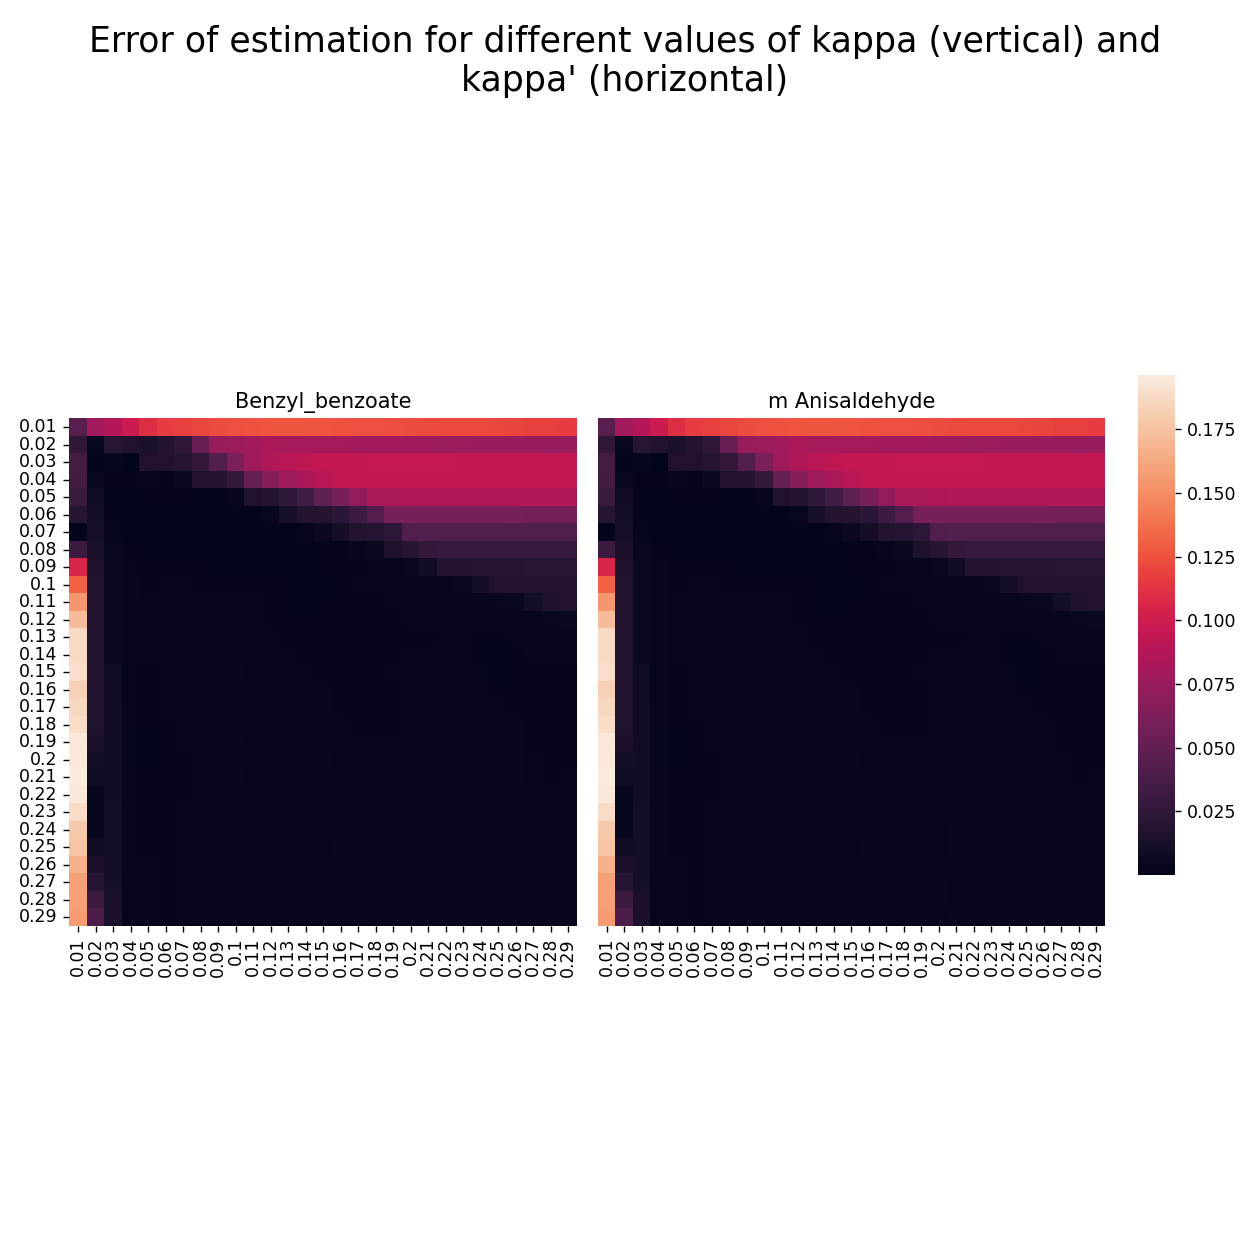

/tmp/ipykernel_288706/3364949664.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [35]:
vmin = min([df.min().min() for df in dataframes_ready_for_heatmap])
vmax = max([df.max().max() for df in dataframes_ready_for_heatmap])
labels = [round(x,3) for x in dataframes_ready_for_heatmap[0]]
#cbar_ax = fig.add_axes([0, 10, 20, 40])
names_for_plot = official_names

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,10), gridspec_kw=dict(width_ratios=2*[1]))
plt.xlabel("kappa'", loc='left')
plt.ylabel('kappa', loc='top')


for i, ax in enumerate(axs.ravel()):
    ax.set_title(names_for_plot[i])
    if i%2==0:
        ax.set_ylabel('kappa')

cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, df in enumerate(dataframes_ready_for_heatmap):

    if i%2==0:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=labels,  cbar=(i==0),
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=None if i else cbar_ax)
                #)
    else:
        sns.heatmap(dataframes_ready_for_heatmap[i].astype(float), yticklabels=False, cbar=False,
                square=True, ax=axs.flat[i], xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True),
                )

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =20)


plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [36]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


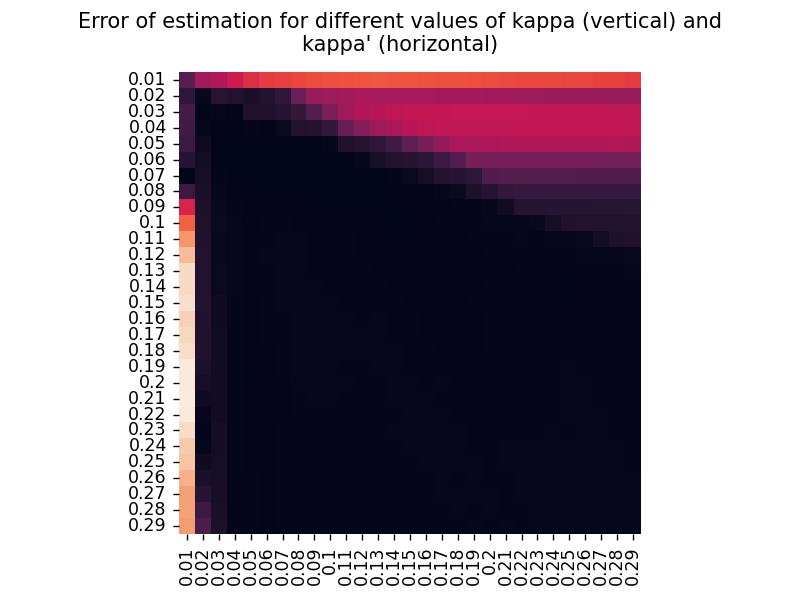

/tmp/ipykernel_288706/3191328942.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [37]:
vmin = all_components_results_molar.min().min()
vmax = all_components_results_molar.max().max()

sns.heatmap(all_components_results_molar.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [38]:
all_components_results_molar.min().min()

3.208105452956467e-07

In [39]:
all_components_results_molar = all_components_results_molar.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [40]:
all_components_results_molar[0.05][0.06999999999999999]

3.208105452956467e-07

#### Visible proportions

In [41]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [42]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [43]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

<IPython.core.display.Javascript object>


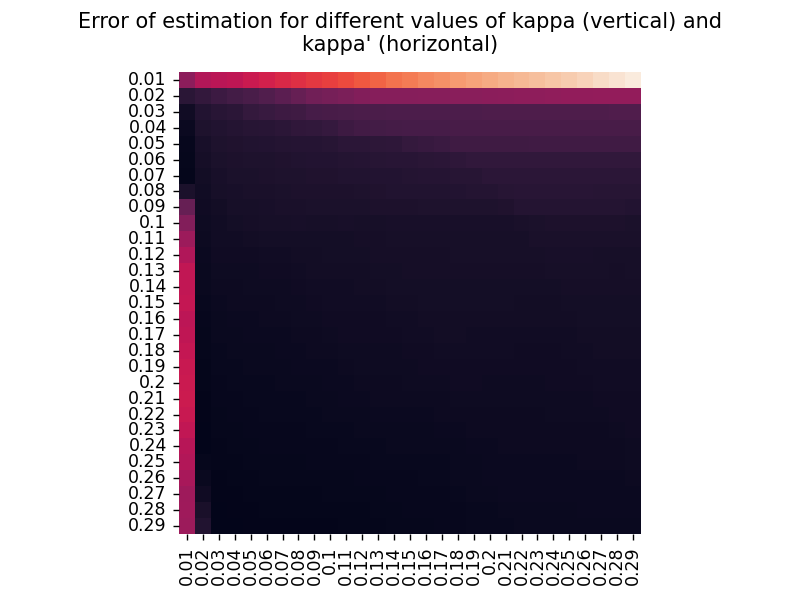

/tmp/ipykernel_288706/1726415674.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [44]:
vmin = all_components_results_vis.min().min()
vmax = all_components_results_vis.max().max()

sns.heatmap(all_components_results_vis.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [45]:
all_components_results_vis = all_components_results_vis.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [46]:
all_components_results_vis.min().min()

0.014654580353985022

In [47]:
all_components_results_vis[0.03][0.29000000000000004]

0.014654580353985022

#### Both together

In [48]:
all_components_results_both = all_components_results_vis + all_components_results_molar

<IPython.core.display.Javascript object>


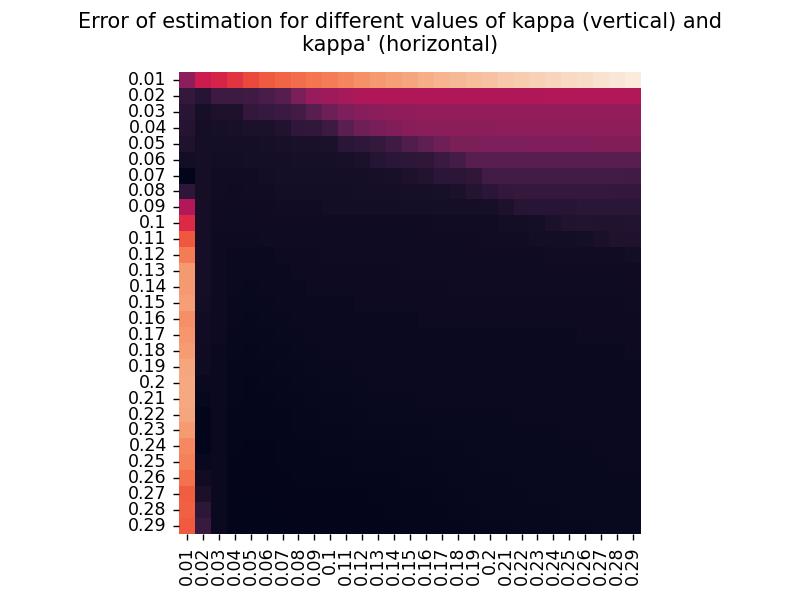

/tmp/ipykernel_288706/424965795.py:12: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


In [49]:
vmin = all_components_results_both.min().min()
vmax = all_components_results_both.max().max()

sns.heatmap(all_components_results_both.astype(float), yticklabels=labels,  cbar=True,
                square=True, xticklabels = labels, vmin=vmin, vmax=vmax,
                cmap=sns.color_palette("rocket", as_cmap=True), cbar_ax=cbar_ax)

plt.suptitle('\n'.join(wrap("Error of estimation for different values of kappa (vertical) and kappa' (horizontal)")), fontsize =12)

plt.show()
#fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])

In [50]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [51]:
all_components_results_both.min().min()

0.02020438273277607

In [52]:
all_components_results_both[0.02][0.23]

0.02020438273277607

### Estimation with best kappa

In [53]:
estimation = estimate_proportions(mix, [comp0, comp1],
                                   MTD=0.23, MTD_th=0.02, verbose=True, solver=pulp.GUROBI())

Initial filtering of formulas: 100%|██████████████| 2/2 [00:00<00:00, 57.63it/s]


Removed theoretical spectra due to no matching experimental peaks: []
Envelope bounds: [(0.0009999999999998899, 15.94445, 0), (0.0009999999999998899, 15.94445, 1)]


Computing chunks: 100%|████████████████████████| 2/2 [00:00<00:00, 67108.86it/s]


Number of chunks: 1
ChunkIDs: [0, 0]
Chunk bounds: [(-0.22900000000000012, 16.17445)]


Splitting the experimental spectrum into chunks: 131072it [00:00, 3104316.43it/s]


Ion currents in chunks: [1.0000000000000153]


Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]

Deconvolving chunk 0


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (linux64)

CPU model: 11th Gen Intel(R) Core(TM) i7-11850H @ 2.50GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 524287 rows, 131075 columns and 1254637 nonzeros
Model fingerprint: 0xc1c19bbe
Coefficient statistics:
  Matrix range     [4e-12, 1e+00]
  Objective range  [4e-12, 1e+00]
  Bounds range     [1e-04, 1e-04]
  RHS range        [1e-04, 2e-01]
Presolve removed 3848 rows and 0 columns (presolve time = 5s) ...
Presolve removed 11976 rows and 0 columns (presolve time = 10s) ...
Presolve removed 21916 rows and 0 columns (presolve time = 15s) ...
Presolve removed 37679 rows and 0 columns (presolve time = 20s) ...
Presolve removed 45773 rows and 0 columns (presolve time = 25s) ...
Presolve removed 154128 rows and 0 columns
Presolve time: 91.14s
Presolve

Deconvolving chunks: 100%|███████████████████████| 1/1 [02:43<00:00, 163.39s/it]

Chunk %i deconvolution status: Optimal
Signal proportion in experimental spectrum: 0.983116421074
Noise proportion in experimental spectrum: 0.01688357892400004
Total explanation: 0.999999999998
Noise proportion in combination of theoretical spectra: 0.240673613042


In [54]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.8714114130920133, 0.11170500798200171]

In [55]:
real_visible_proportions

[0.8876121810260892, 0.1123878189739109]

In [56]:
estimated_molar_proportions = [estimated_visible_proportions[0]/protons[0], estimated_visible_proportions[1]/protons[1]]
estimated_molar_proportions = [mp/sum(estimated_molar_proportions) for mp in estimated_molar_proportions]
estimated_molar_proportions

[0.8387271188476428, 0.16127288115235716]

In [57]:
molar_proportions

[0.8403875207510383, 0.1596124792489616]

### Visualisation of our estimation

In [58]:
p = estimated_visible_proportions

In [59]:
p = np.array(p).reshape(len(p),1)

In [60]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [61]:
components_ints = [comp_int.reshape(-1,1) for comp_int in components_ints]

In [62]:
X = np.concatenate(components_ints, axis=1)

In [63]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


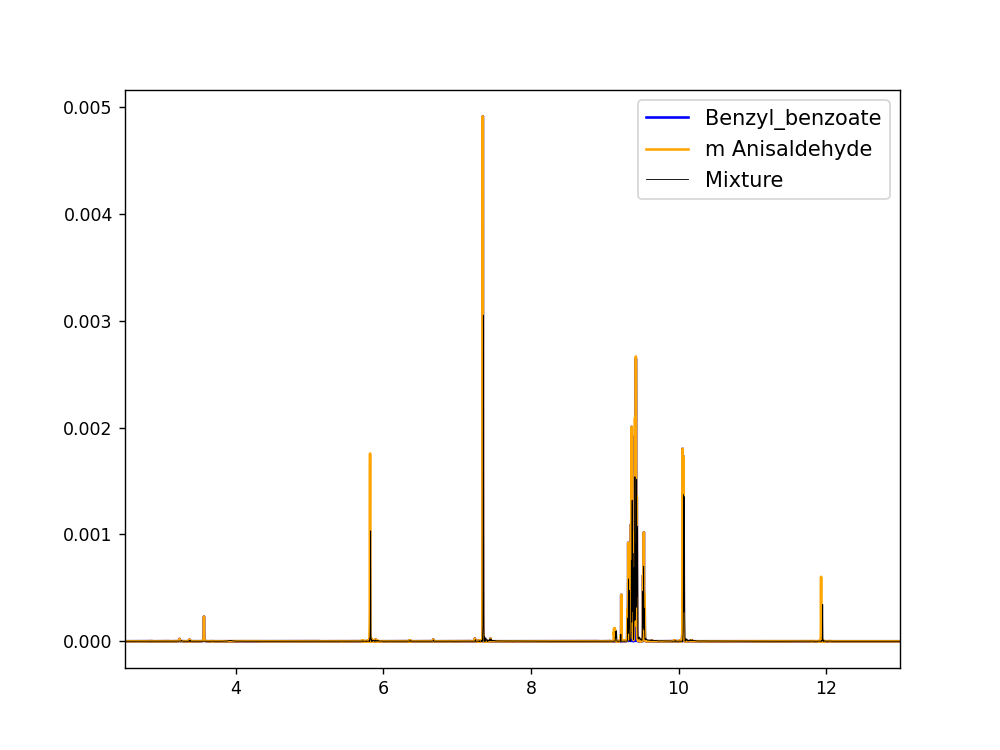

In [64]:
colors = ['blue', 'orange', 'green', 'red']
fig, ax = plt.subplots()
fig.set_size_inches(8, 6, forward=True)
ax.set_xlim(2.5, 13)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})

